# Projet 6

In [2]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
import gc
import time
from contextlib import contextmanager
import warnings
import numpy as np
from datetime import datetime
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from dotenv import load_dotenv
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
import spacy
import re
from nltk.stem.snowball import SnowballStemmer
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic

In [3]:
from emot.emo_unicode import UNICODE_EMOJI as UNICODE_EMO# For emojis
from emot.emo_unicode import EMOTICONS_EMO# For EMOTICONS

In [ ]:
%flake8_off

ValueError: Function <bound method VarWatcher.auto_run_flake8 of <pycodestyle_magic.VarWatcher object at 0x0000028B7A2D1310>> is not registered as a post_run_cell callback

In [4]:
# chargement des variables d'environnment
load_dotenv() 

Python-dotenv could not parse statement starting at line 1


True

# Collecte des données

Uniquement API ? Les fichiers json ?

In [5]:
api_key = os.getenv('API_KEY')
endpoint = "https://api.yelp.com/v3/graphql"

Réalisons une fonction pour réaliser des requêtes en GraphQL. On utilise cette solution afin de pouvoir collecter les informations uniquement des champs qui nous intéressent.

In [6]:
def request_client(api_key, endpoint, query):
    reqHeaders = {
        'Authorization': 'Bearer ' + api_key 
    }

    _transport = RequestsHTTPTransport(
        url=endpoint,
        headers = reqHeaders,
        use_json=True,
    )

    client = Client(
        transport = _transport,
        fetch_schema_from_transport=True,
    )

    result = client.execute(query)
    return result

In [175]:
# le max de review est de 3 par restaurant, on importe toutes les données
restaurants=[]
j = 0
for i in range(0,8):
    query = """
                {
                search(term:"restaurant",
                        location: "France"
                        limit:50,
                        offset:"""+str(j)+"""
                        ) {
                    business {
                    id,
                    name,
                    photos,
                    reviews{
                        id,
                        text,
                        rating
                    }
                    }
                }
                }
            """
    query = gql(query)
    temp = request_client(api_key, endpoint, query)["search"]["business"]
    restaurants.extend(temp)
    print("nb restaurants ", len(restaurants))
    j=j+51
    

TransportQueryError: {'message': 'Something went wrong internally, please try again later.', 'locations': [{'line': 2, 'column': 3}], 'path': ['search'], 'extensions': {'code': 'INTERNAL_ERROR'}}

In [18]:
restaurants = pd.DataFrame(restaurants)

In [101]:
restaurants.head(2)

,id,name,photos,reviews
0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,[https://s3-media2.fl.yelpcdn.com/bphoto/TtMQl...,"[{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My ..."
1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,[https://s3-media4.fl.yelpcdn.com/bphoto/J9RBy...,"[{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'Thi..."


# Construction des bases de données

On scinde notre fichier en deux afin de traiter le texte et les photos séparément.

In [104]:
df = restaurants.copy()

In [105]:
df.head(2)

,id,name,photos,reviews
0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,[https://s3-media2.fl.yelpcdn.com/bphoto/TtMQl...,"[{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My ..."
1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,[https://s3-media4.fl.yelpcdn.com/bphoto/J9RBy...,"[{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'Thi..."


In [106]:
df['reviews'].apply(pd.Series)[0].apply(pd.Series)

,0,id,rating,text
0,NaN,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,NaN,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,NaN,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,NaN,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,NaN,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...,...
195,NaN,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,NaN,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,NaN,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,NaN,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [50]:
df

,Unnamed: 0,id,name,photos,rw_id,rw_rating,rw_text
0,0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQ...,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,['https://s3-media4.fl.yelpcdn.com/bphoto/J9RB...,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,2,KggnM_Z4wOa_JExunaaWHg,Le Temps des Cerises,['https://s3-media1.fl.yelpcdn.com/bphoto/g3Aa...,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,3,WHHt_Jb8Tgidn9mW7oDnIg,La Coïncidence,['https://s3-media1.fl.yelpcdn.com/bphoto/QdrA...,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,4,_qACPRqSQ6Nvd20H8EY3uw,Frenchie Restaurant,['https://s3-media2.fl.yelpcdn.com/bphoto/E8EG...,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...,...,...,...,...
195,195,26YjCdVvyn5jv4sZYd1Lvw,Loup,['https://s3-media2.fl.yelpcdn.com/bphoto/M1pg...,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,196,MN-I5rJBYAZwp2jeHXs_JQ,L'Alsacien,['https://s3-media3.fl.yelpcdn.com/bphoto/Um1i...,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,197,fK5KhHO8az5LVmzOPsED2g,Miznon,['https://s3-media3.fl.yelpcdn.com/bphoto/q_AO...,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,198,R44YZMAdHQFB9BCIUcwnhA,Machon d'Henri Le,['https://s3-media1.fl.yelpcdn.com/bphoto/n6_5...,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [108]:
df = pd.concat([df.drop(['reviews'], axis=1), 
    df['reviews'].apply(pd.Series)[0].apply(pd.Series)]
    , axis=1)


In [109]:
df.columns

Index(['id', 'name', 'photos', 0, 'id', 'rating', 'text'], dtype='object')

In [110]:
df.columns = ['id', 'name', 'photos','pb', 'rw_id', 
          'rw_rating','rw_text']

In [111]:
del df["pb"]

Exportons les données en csv

In [112]:
df.to_csv('output/restaurants_v2.csv')

Requête pour importer les données.

In [8]:
df = pd.read_csv('output/restaurants_v2.csv')

In [9]:
df
#del df["Unnamed: 0"]

,Unnamed: 0,id,name,photos,rw_id,rw_rating,rw_text
0,0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQ...,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,1,IU9_wVOGBKjfqTTpAXpKcQ,Bistro des Augustins,['https://s3-media4.fl.yelpcdn.com/bphoto/J9RB...,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,2,KggnM_Z4wOa_JExunaaWHg,Le Temps des Cerises,['https://s3-media1.fl.yelpcdn.com/bphoto/g3Aa...,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,3,WHHt_Jb8Tgidn9mW7oDnIg,La Coïncidence,['https://s3-media1.fl.yelpcdn.com/bphoto/QdrA...,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,4,_qACPRqSQ6Nvd20H8EY3uw,Frenchie Restaurant,['https://s3-media2.fl.yelpcdn.com/bphoto/E8EG...,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...,...,...,...,...
195,195,26YjCdVvyn5jv4sZYd1Lvw,Loup,['https://s3-media2.fl.yelpcdn.com/bphoto/M1pg...,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,196,MN-I5rJBYAZwp2jeHXs_JQ,L'Alsacien,['https://s3-media3.fl.yelpcdn.com/bphoto/Um1i...,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,197,fK5KhHO8az5LVmzOPsED2g,Miznon,['https://s3-media3.fl.yelpcdn.com/bphoto/q_AO...,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,198,R44YZMAdHQFB9BCIUcwnhA,Machon d'Henri Le,['https://s3-media1.fl.yelpcdn.com/bphoto/n6_5...,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [10]:
reviews = df[["rw_id", "rw_rating", "rw_text"]].copy()

In [11]:
reviews["rw_rating"].unique()

array([ 5.,  4., nan,  3.,  1.])

In [12]:
photos = df[["id", "photos"]]

# Analyse des données

## Pré traitement des données textuelles

Analysons le texte en premier lieu

In [28]:
reviews

,rw_id,rw_rating,rw_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


Regardons le nombre de commentaire par note. Traçons un diagramme en barre

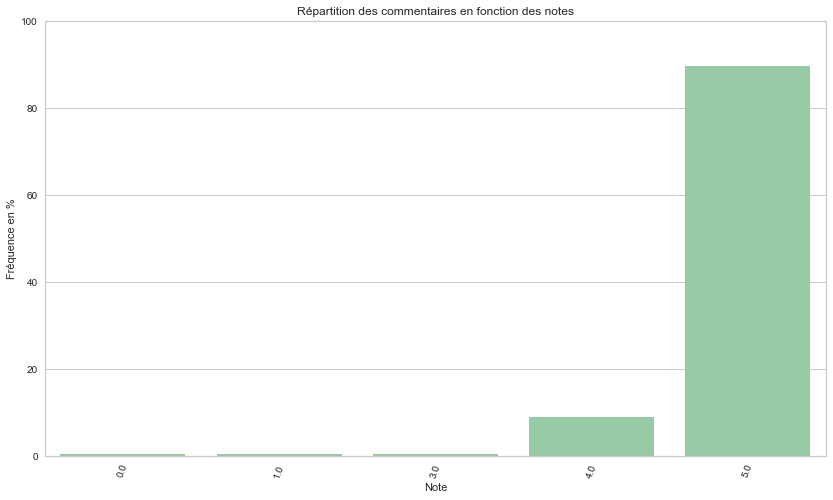

In [66]:
pk.graph_barplot(reviews['rw_rating'],
                  "Répartition des commentaires en fonction des notes", 
                   (0.564, 0.823, 0.631),
                   0, 100, "Note", "Fréquence en %",70, 1, (14,8))

In [67]:
reviews['rw_rating'].describe()

count    200.000000
mean       4.855000
std        0.543555
min        0.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: rw_rating, dtype: float64

Le but est de découvrir les sujets insatisfaisants, nous commençons par compter le nombre de mots.

In [40]:
reviews

,rw_id,rw_rating,rw_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,My favorite meal in Paris! \n\nWe started off ...
1,-to6adg_kucf1SgQckgJXw,5.0,This is a small bar/restaurant closed to Cathé...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,"Foods were delicious, great ambiance, and help..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,"this is for a review from 2019, this place is ..."
4,giErkj8Al6-egq5XUu2FqA,5.0,Michelin starred. Reservations weeks in advanc...
...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,"Paris, France\n\nHangry? \n\nWhen the most pop..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,Stopped here for dinner on our first night in ...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,Everything on the menu seems to be fully maste...
198,dkkicroZxI_fOiPW4B_GZw,5.0,My husband and I wanted to try a coq au vin wh...


In [41]:
reviews["rw_text"]

0      My favorite meal in Paris! \n\nWe started off ...
1      This is a small bar/restaurant closed to Cathé...
2      Foods were delicious, great ambiance, and help...
3      this is for a review from 2019, this place is ...
4      Michelin starred. Reservations weeks in advanc...
                             ...                        
195    Paris, France\n\nHangry? \n\nWhen the most pop...
196    Stopped here for dinner on our first night in ...
197    Everything on the menu seems to be fully maste...
198    My husband and I wanted to try a coq au vin wh...
199    Hard to find a nice French restaurant without ...
Name: rw_text, Length: 200, dtype: object

Nous observons des retours à la ligne "\n" et la présence de ponctuation dans le texte. Il faut donc supprimer ces caractères. Cependant, il faut faire attention car il se peut qu'il y ait des smileys.
Créons une fonction pour traiter le texte.

In [13]:
def text_cleaning(text, ponct, only_letters, numbers):
    text = text.lower()
    ponctuation = "[^!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]"
    number = "[^0-9]"
    letters = "[^a-zA-Z ]"
    if ponct == 1:
        text = re.sub(ponctuation, '', text)
    if only_letters == 1:
        text = re.sub(letters, '', text)
    if numbers == 1:
        text = re.sub(number, '', text)
    return text

In [14]:
# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text# Example


In [15]:
text1 = "Hilarious :) 😂. The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒"
convert_emojis(text1)

'Hilarious :) face_with_tears_of_joy. The feeling of making a sale smiling_face_with_sunglasses, The feeling of actually fulfilling orders unamused_face'

In [16]:
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
    return text


text = "Hello :-) :-)"
convert_emoticons(text)

'Hello Happy_face_smiley Happy_face_smiley'

Réécrivons les contractions en entier.

In [17]:
import contractions

test = contractions.fix("shouldn't")
test

'should not'

Nous avons des commentaires vides, nous décidons de mettre 0 pour les notes et un vide pour les valeurs Nan des commentaires.

In [18]:
reviews["rw_text"] = reviews["rw_text"].fillna("")

In [19]:
reviews["rw_rating"] = reviews["rw_rating"].fillna(0)

In [20]:
reviews["rw_text"] = reviews["rw_text"].str.lower()
for index, element in reviews.iterrows():
    #tokenizer = nltk.RegexpTokenizer(r'\w+')
    element["rw_text"] = convert_emojis(element["rw_text"])
    element["rw_text"] = convert_emoticons(element["rw_text"])
    element["rw_text"] = text_cleaning(element["rw_text"],0 , 1, 0)
    element["rw_text"] = contractions.fix(element["rw_text"])
    #tokens = tokenizer.tokenize(element["rw_text"])
    tokens = element["rw_text"].split()
    reviews.loc[index, "rw_text"] = element["rw_text"]
    reviews.loc[index, "nb_words"] = len(tokens)
    reviews.loc[index, "words"] = str(tokens)

In [156]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'..."
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', ..."
2,U8G3f8ITSlqBzETBDVO8bw,5.0,foods were delicious great ambiance and helpfu...,24.0,"['foods', 'were', 'delicious', 'great', 'ambia..."
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,this is for a review from this place is perfe...,22.0,"['this', 'is', 'for', 'a', 'review', 'from', '..."
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred reservations weeks in advance...,23.0,"['michelin', 'starred', 'reservations', 'weeks..."
...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,paris francehangry when the most popular place...,26.0,"['paris', 'francehangry', 'when', 'the', 'most..."
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'ou..."
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully maste...,28.0,"['everything', 'on', 'the', 'menu', 'seems', '..."
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin wh...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', ..."


In [157]:
graph = reviews.sort_values(by='nb_words', ascending=False)
pk.graph_intv_bar(graph, 'rw_id', 'nb_words', "rw_id", "nb words", 'redor', "Nombre de mots par commentaire")

In [158]:
reviews["nb_words"].describe()

count    200.000000
mean      27.205000
std        3.649599
min        0.000000
25%       25.000000
50%       28.000000
75%       30.000000
max       34.000000
Name: nb_words, dtype: float64

Nous avons en moyenne 26 mots par commentaire. Et 50% des commentaires font plus de 27 mots.

Regardons les mots les plus fréquents

In [37]:
words = nltk.tokenize.word_tokenize(" ".join(reviews['rw_text']))

In [160]:
word_dist = nltk.FreqDist(words)



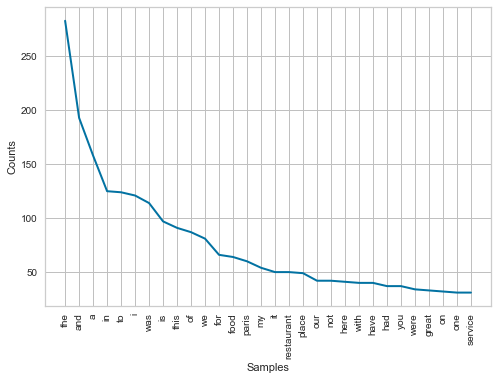

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [161]:
fdist = nltk.FreqDist(words)
fdist.plot(30)

Nous observons qu'il y a des déterminants de type : the, in, a qui sont très fréquent.
Nous devons supprimer ces mots car il n'apporte pas d'informations sur le sujet ou le sentiment du commentaire.

Réalisons une fonction pour compter le nombre de mot et faire le graphique

In [21]:
def nb_most_frequent_plt(df_var):
    words = nltk.tokenize.word_tokenize(" ".join(df_var))
    fdist = nltk.FreqDist(words)
    fdist.plot(30)

In [22]:
gc.collect()

1116

Essayons d'utiliser la bibliothèque nltk

In [23]:
from nltk.corpus import stopwords
nltk.download('stopwords')

sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dans la liste stopwords du package, il y a des mots qui sont importants pour l'identification des sentiments comme "very" ou les négations ("not"...).
Supprimons ces éléments de la liste de stopwords. De plus, le package supprime certains verbes comme be et have. Nous voulons garder ces verbes pour l'analyse de sentiment.

In [24]:
keep_words = ["you're", "you've", "you'd", "she's", "it's", 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'not', 
              'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'but', 'if', 'because', 'against', 'between', 
              'during', 'before', 'after', 'again', 'once', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 
              'such', 'only', 'own', 'same', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
              'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
              'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', 
              "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
new_sw_nltk = [word for word in sw_nltk if word not in keep_words]

new_sw_nltk.extend(['th','pm', 's', 'er', 'paris', 'rst', 'st', 'am'])

Ces mots n'apportent pas de sens concernant les sentiments dans les phrases. Autrement dit, ce sont des mots dit vides pour notre projet.

In [25]:
pat = r'\b(?:{})\b'.format('|'.join(new_sw_nltk))
cleaning = reviews['rw_text'].str.replace(pat, '')
reviews['new_words'] = cleaning.apply(lambda x: nltk.word_tokenize(x))
reviews['new_text'] = cleaning



In [26]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","[favorite, meal, started, foie, gras, carpacci...",favorite meal started foie gras carpacc...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', ...","[is, small, barrestaurant, closed, cathdrale, ...",is small barrestaurant closed cathdrale not...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,foods were delicious great ambiance and helpfu...,24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","[foods, were, delicious, great, ambiance, help...",foods were delicious great ambiance helpful s...
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,this is for a review from this place is perfe...,22.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","[is, review, place, is, perfect, would, recomm...",is review place is perfect would recomme...
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred reservations weeks in advance...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","[michelin, starred, reservations, weeks, advan...",michelin starred reservations weeks advance i...
...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,paris francehangry when the most popular place...,26.0,"['paris', 'francehangry', 'when', 'the', 'most...","[francehangry, most, popular, places, are, pac...",francehangry most popular places are packed...
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'ou...","[stopped, dinner, first, night, gai, stayed, a...",stopped dinner first night gai stayed ...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully maste...,28.0,"['everything', 'on', 'the', 'menu', 'seems', '...","[everything, menu, seems, be, fully, mastered,...",everything menu seems be fully mastered fl...
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin wh...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', ...","[husband, wanted, try, coq, au, vin, were, fra...",husband wanted try coq au vin were fra...


Etudions à nouveau les mots les plus fréquents.

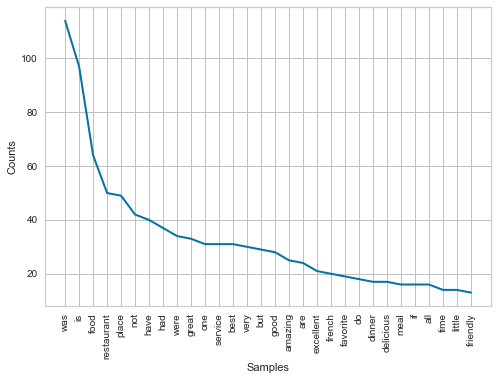

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [27]:
words = nltk.tokenize.word_tokenize(" ".join(reviews["new_text"]))
fdist = nltk.FreqDist(words)
fdist.plot(30)

Nous n'avons plus de mots dit vides. Il nous faut à présent conserver la racine des mots.
Il existe deux méthodes : Stemming et lemmatization.
Stemming supprime les suffixes et les préfixes des mots sans prendre en considération le contexte. 
Contrairement à la méthode stemming, la méthode lemmatization considère le contexte et convertit le mot dans sa forme de base "significative".

In [170]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","[favorite, meal, started, foie, gras, carpacci...",favorite meal started foie gras carpacc...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', ...","[is, small, barrestaurant, closed, cathdrale, ...",is small barrestaurant closed cathdrale not...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,foods were delicious great ambiance and helpfu...,24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","[foods, were, delicious, great, ambiance, help...",foods were delicious great ambiance helpful s...
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,this is for a review from this place is perfe...,22.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","[is, review, place, is, perfect, would, recomm...",is review place is perfect would recomme...
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred reservations weeks in advance...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","[michelin, starred, reservations, weeks, advan...",michelin starred reservations weeks advance i...
...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,paris francehangry when the most popular place...,26.0,"['paris', 'francehangry', 'when', 'the', 'most...","[francehangry, most, popular, places, are, pac...",francehangry most popular places are packed...
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'ou...","[stopped, dinner, first, night, gai, stayed, a...",stopped dinner first night gai stayed ...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully maste...,28.0,"['everything', 'on', 'the', 'menu', 'seems', '...","[everything, menu, seems, be, fully, mastered,...",everything menu seems be fully mastered fl...
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin wh...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', ...","[husband, wanted, try, coq, au, vin, were, fra...",husband wanted try coq au vin were fra...


Créons une fonction pour utiliser ces méthodes.

In [28]:
def stems(word):
    stemmer = SnowballStemmer(language='english')
    return stemmer.stem(word)
 
def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return lemmatizer.lemmatize(text)

In [30]:
stems("running")

'run'

In [31]:
lemmatize_text("runs")

'run'

In [29]:
def short_words(text, lem_stem, new_var, var_to_convert):
    if lem_stem == 1: 
        stemmer = SnowballStemmer(language='english')
        reviews[new_var] = reviews[var_to_convert].apply(lambda x: " ".join([stemmer.stem(y) for y in x]))
    if lem_stem == 2:
        reviews[new_var] = reviews[var_to_convert].apply(lambda x: " ".join([lemmatize_text(y) for y in x]))

In [30]:
short_words(text, 1, 'stemmed', 'new_words')

In [31]:
short_words(text, 2, 'lemmatized', 'new_words')

In [32]:
reviews

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","[favorite, meal, started, foie, gras, carpacci...",favorite meal started foie gras carpacc...,favorit meal start foie gras carpaccio escargo...,favorite meal started foie gras carpaccio esca...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', ...","[is, small, barrestaurant, closed, cathdrale, ...",is small barrestaurant closed cathdrale not...,is small barrestaur close cathdral notr dame a...,is small barrestaurant closed cathdrale notre ...
2,U8G3f8ITSlqBzETBDVO8bw,5.0,foods were delicious great ambiance and helpfu...,24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","[foods, were, delicious, great, ambiance, help...",foods were delicious great ambiance helpful s...,food were delici great ambianc help staff riso...,food were delicious great ambiance helpful sta...
3,WMRKQUUR3BmjV_EZg7zVfw,5.0,this is for a review from this place is perfe...,22.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","[is, review, place, is, perfect, would, recomm...",is review place is perfect would recomme...,is review place is perfect would recommend pri...,is review place is perfect would recommend pri...
4,giErkj8Al6-egq5XUu2FqA,5.0,michelin starred reservations weeks in advance...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","[michelin, starred, reservations, weeks, advan...",michelin starred reservations weeks advance i...,michelin star reserv week advanc is absolut ne...,michelin starred reservation week advance is a...
...,...,...,...,...,...,...,...,...,...
195,APBAlRXsEX0-B_lwYXFSzw,4.0,paris francehangry when the most popular place...,26.0,"['paris', 'francehangry', 'when', 'the', 'most...","[francehangry, most, popular, places, are, pac...",francehangry most popular places are packed...,francehangri most popular place are pack au pi...,francehangry most popular place are packed au ...
196,37Klq0mvBK1WkxnhI0HRCg,5.0,stopped here for dinner on our first night in ...,29.0,"['stopped', 'here', 'for', 'dinner', 'on', 'ou...","[stopped, dinner, first, night, gai, stayed, a...",stopped dinner first night gai stayed ...,stop dinner first night gai stay arrondiss wal...,stopped dinner first night gai stayed arrondis...
197,K--hr3q7hJFXuFvZbQTM7Q,5.0,everything on the menu seems to be fully maste...,28.0,"['everything', 'on', 'the', 'menu', 'seems', '...","[everything, menu, seems, be, fully, mastered,...",everything menu seems be fully mastered fl...,everyth menu seem be fulli master flavor are a...,everything menu seems be fully mastered flavor...
198,dkkicroZxI_fOiPW4B_GZw,5.0,my husband and i wanted to try a coq au vin wh...,34.0,"['my', 'husband', 'and', 'i', 'wanted', 'to', ...","[husband, wanted, try, coq, au, vin, were, fra...",husband wanted try coq au vin were fra...,husband want tri coq au vin were franc unfortu...,husband wanted try coq au vin were france unfo...


Regardons les mots les plus fréquents pour ces deux colonnes

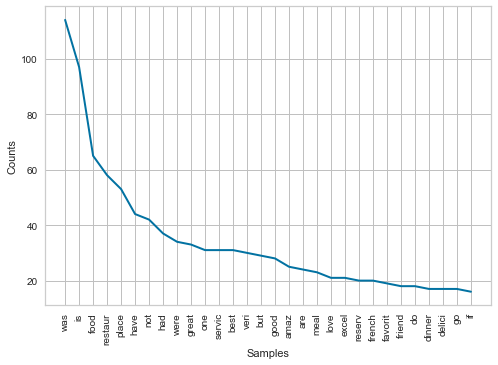

In [52]:
nb_most_frequent_plt(reviews["stemmed"])

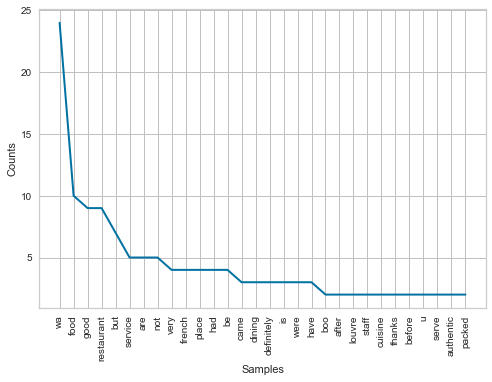

In [176]:
nb_most_frequent_plt(reviews["lemmatized"])

In [53]:
reviews.head(2)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","[favorite, meal, started, foie, gras, carpacci...",favorite meal started foie gras carpacc...,favorit meal start foie gras carpaccio escargo...,favorite meal started foie gras carpaccio esca...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', ...","[is, small, barrestaurant, closed, cathdrale, ...",is small barrestaurant closed cathdrale not...,is small barrestaur close cathdral notr dame a...,is small barrestaurant closed cathdrale notre ...


In [40]:
trigrams_all= []
for element in reviews["words_ok"]:
    token = nltk.word_tokenize(element)
    trigrams = ngrams(token,3)
    trigrams_all.append(list(trigrams))
    break
trigrams_all

[[('favorit', 'meal', 'start'),
  ('meal', 'start', 'off'),
  ('start', 'off', 'foie'),
  ('off', 'foie', 'gras'),
  ('foie', 'gras', 'carpaccio'),
  ('gras', 'carpaccio', 'escargot'),
  ('carpaccio', 'escargot', 'love'),
  ('escargot', 'love', 'uniqu'),
  ('love', 'uniqu', 'way'),
  ('uniqu', 'way', 'foie'),
  ('way', 'foie', 'gras'),
  ('foie', 'gras', 'was'),
  ('gras', 'was', 'prepar'),
  ('was', 'prepar', 'thinly')]]

In [35]:
gc.collect()

0

In [55]:
reviews.head(2)

,rw_id,rw_rating,rw_text,nb_words,words,new_words,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","[favorite, meal, started, foie, gras, carpacci...",favorite meal started foie gras carpacc...,favorit meal start foie gras carpaccio escargo...,favorite meal started foie gras carpaccio esca...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,29.0,"['this', 'is', 'a', 'small', 'barrestaurant', ...","[is, small, barrestaurant, closed, cathdrale, ...",is small barrestaurant closed cathdrale not...,is small barrestaur close cathdral notr dame a...,is small barrestaurant closed cathdrale notre ...


nous pouvons supprimer les colonnes inutiles

In [33]:
del reviews["nb_words"]

In [34]:
reviews = reviews.drop(["new_words", "words"], axis=1)

In [35]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,favorite meal started foie gras carpacc...,favorit meal start foie gras carpaccio escargo...,favorite meal started foie gras carpaccio esca...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,is small barrestaurant closed cathdrale not...,is small barrestaur close cathdral notr dame a...,is small barrestaurant closed cathdrale notre ...


Ajoutons des tags pour connaitre la nature de chaque mot.

In [39]:
nltk.word_tokenize("toto est dans ")

['toto', 'est', 'dans']

In [36]:
def word_pos_tagger(list_words):
    pos_tagged_text = nltk.pos_tag(list_words)
    return pos_tagged_text

In [37]:
all_reviews = reviews["new_text"].str.cat(sep=' ')

In [38]:
description_words = word_pos_tagger(nltk.word_tokenize(all_reviews))

In [39]:
description_words

[('favorite', 'JJ'),
 ('meal', 'NN'),
 ('started', 'VBD'),
 ('foie', 'JJ'),
 ('gras', 'NNS'),
 ('carpaccio', 'VBP'),
 ('escargot', 'RB'),
 ('love', 'VB'),
 ('unique', 'JJ'),
 ('way', 'NN'),
 ('foie', 'NN'),
 ('gras', 'NN'),
 ('was', 'VBD'),
 ('prepared', 'VBN'),
 ('thinly', 'RB'),
 ('is', 'VBZ'),
 ('small', 'JJ'),
 ('barrestaurant', 'NN'),
 ('closed', 'VBD'),
 ('cathdrale', 'NN'),
 ('notre', 'NN'),
 ('dame', 'NN'),
 ('always', 'RB'),
 ('come', 'VBN'),
 ('lunch', 'NN'),
 ('dinner', 'NN'),
 ('if', 'IN'),
 ('close', 'JJ'),
 ('hostess', 'NN'),
 ('is', 'VBZ'),
 ('very', 'RB'),
 ('friendly', 'JJ'),
 ('foods', 'NNS'),
 ('were', 'VBD'),
 ('delicious', 'JJ'),
 ('great', 'JJ'),
 ('ambiance', 'NN'),
 ('helpful', 'JJ'),
 ('staffs', 'NNS'),
 ('risotto', 'VBP'),
 ('cooked', 'VBN'),
 ('perfectly', 'RB'),
 ('got', 'VBD'),
 ('white', 'JJ'),
 ('fish', 'JJ'),
 ('house', 'NN'),
 ('white', 'JJ'),
 ('sauce', 'NN'),
 ('tasta', 'NN'),
 ('like', 'IN'),
 ('fennel', 'NN'),
 ('is', 'VBZ'),
 ('review', 'JJ'),
 ('p

In [43]:
tag_fd = nltk.FreqDist(tag for (word, tag) in description_words)

In [44]:
list_keep = []
list_excl = ['IN', 'DT', 'CD', 'CC', 'RP', 'WDT', 'EX']
for word, tag in description_words:
    if tag not in list_excl:
        list_keep.append(tag)

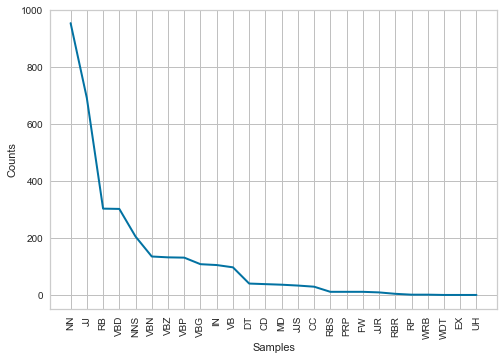

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [45]:
tag_fd.plot()

UH = interjection (expression affective > ha, oh)
EX = existentiel (ex : il y a)
WDT = wh-déterminant (ex : qui)
pour plus d'informations, voir : https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/

On exclut : IN, DT, CD, CC, RP, WDT, EX


In [46]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,favorite meal started foie gras carpacc...,favorit meal start foie gras carpaccio escargo...,favorite meal started foie gras carpaccio esca...
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,is small barrestaurant closed cathdrale not...,is small barrestaur close cathdral notr dame a...,is small barrestaurant closed cathdrale notre ...


In [47]:
reviews["text_tokens_pos_tagged"] =  reviews["new_text"].apply(lambda x: " ".join([y for y, tag in word_pos_tagger(nltk.word_tokenize(x)) if tag in list_keep]))

In [48]:
list_nouns = ["NN", "NNS", "NNP", "NNPS"]
reviews["words_subjects"] =  reviews["lemmatized"].apply(lambda x: " ".join([y for y, tag in word_pos_tagger(nltk.word_tokenize(x)) if tag in list_nouns]))

In [49]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,favorite meal started foie gras carpacc...,favorit meal start foie gras carpaccio escargo...,favorite meal started foie gras carpaccio esca...,favorite meal started foie gras carpaccio esca...,meal gras way gras
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,is small barrestaurant closed cathdrale not...,is small barrestaur close cathdral notr dame a...,is small barrestaurant closed cathdrale notre ...,is small barrestaurant closed cathdrale notre ...,barrestaurant cathdrale notre dame lunch dinne...


Nous utilisons Vader pour obtenir les impressions de sentiments des couples de mots(positif, neutre, negatif).

Créons une fonction pour obtenir des informations sur les sentiments des groupes de mots.

In [50]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict

In [51]:
for idx, review in reviews.iterrows():

    # pour les sentiments, on regarde le texte en entier car il nous faut les adjectifs
    res_sentiments = sentiment_scores(review["text_tokens_pos_tagged"])
    
    # decide sentiment as positive, negative and neutral
    if res_sentiments['compound'] >= 0.6 and res_sentiments['pos']>0.5 :
        feeling_avg = "Positive"
    elif res_sentiments['compound'] <= - 0.5  and res_sentiments['neg'] > 0.3 :
        feeling_avg = "Negative"
    else :
        feeling_avg = "Neutral"

    reviews.loc[idx, "feeling_neg"] = res_sentiments['neg']
    reviews.loc[idx, "feeling_neu"] = res_sentiments['neu']
    reviews.loc[idx, "compound"] = res_sentiments['compound']
    reviews.loc[idx, "feeling_pos"] = res_sentiments['pos']
    reviews.loc[idx, "feeling_avg"] = feeling_avg

In [52]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,compound,feeling_pos,feeling_avg
0,aGP7nLwEQOUg64jKP8ebsw,5.0,my favorite meal in paris we started off with ...,favorite meal started foie gras carpacc...,favorit meal start foie gras carpaccio escargo...,favorite meal started foie gras carpaccio esca...,favorite meal started foie gras carpaccio esca...,meal gras way gras,0.0,0.569,0.8442,0.431,Neutral
1,-to6adg_kucf1SgQckgJXw,5.0,this is a small barrestaurant closed to cathdr...,is small barrestaurant closed cathdrale not...,is small barrestaur close cathdral notr dame a...,is small barrestaurant closed cathdrale notre ...,is small barrestaurant closed cathdrale notre ...,barrestaurant cathdrale notre dame lunch dinne...,0.0,0.811,0.5413,0.189,Neutral


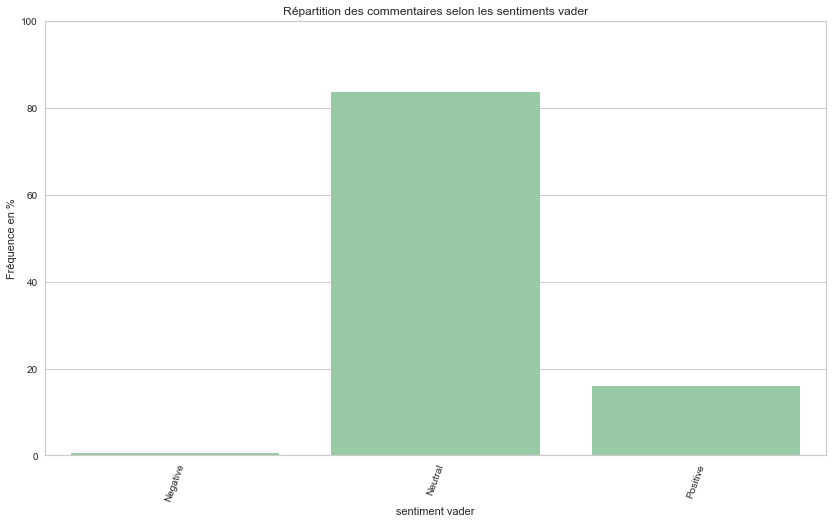

In [53]:
pk.graph_barplot(reviews['feeling_avg'],
                  "Répartition des commentaires selon les sentiments vader",
                  (0.564, 0.823, 0.631),
                   0, 100, "sentiment vader", "Fréquence en %",70, 1, (14,8))

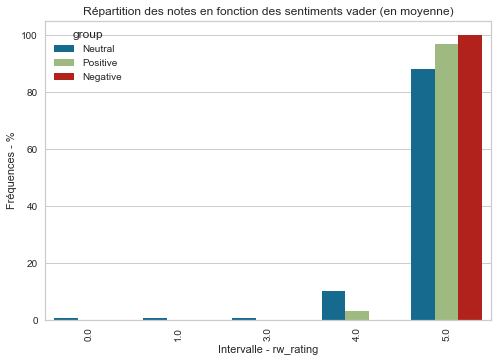

In [54]:
pk.graph_barplot_by_group(reviews, 'rw_rating', 'feeling_avg', '#6D8260', 'Répartition des notes en fonction des sentiments vader (en moyenne)')


In [55]:
for i in reviews.loc[reviews["feeling_avg"]=='Negative']["rw_text"].head(10):
    print(i)

michelin one thing ill always carry with me when i think back on my trip to paris was not only the food because its amazing but the smell of the


In [56]:
for idx, i in reviews.loc[reviews["rw_rating"]==5].head(10).iterrows():
    print(i["rw_text"], " ", str(i["compound"]))

my favorite meal in paris we started off with the foie gras carpaccio and escargot love the unique way that the foie gras was prepared and so thinly   0.8442
this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or dinner if i am close by the hostess is very friendly the   0.5413
foods were delicious great ambiance and helpful staffs the risotto cooked perfectly i got the white fish with house white sauce tasta like fennel   0.9413
this is for a review from  this place is perfect would recommend  prices are great food is astoundingand i never leave reviews   0.8872
michelin starred reservations weeks in advance is absolutely necessary to dine at an establishment like this my second time here very sophisticated vibe   0.5984
when i visited paris last week i had stopped by here by a recommendation of a friend and also recommended by bourdain this place was amazing and lives up   0.7845
based on some research we decided to book a reservation here for a 

Nous conservons les reviews inférieur ou égal à 5.

In [57]:
reviews_sav = reviews.copy()

In [58]:
reviews = reviews_sav.loc[reviews_sav["rw_rating"]<5].copy()

In [59]:
reviews.describe()

,rw_rating,feeling_neg,feeling_neu,compound,feeling_pos
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,3.619048,0.022524,0.637429,0.611495,0.292381
std,1.071270,0.038499,0.225536,0.314978,0.168617
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.527000,0.475400,0.162000
50%,4.000000,0.000000,0.632000,0.750600,0.297000
75%,4.000000,0.047000,0.769000,0.859100,0.436000
max,4.000000,0.117000,1.000000,0.923000,0.564000


Regardons les sujets qui ressortent à l'aide d'un graphique word cloud

In [60]:
from wordcloud import WordCloud
from PIL import Image

In [61]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,compound,feeling_pos,feeling_avg
22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hour louvre museum wa wait staff setup...,0.000,1.000,0.000,0.000,Neutral
31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks guidance call restau...,0.047,0.389,0.923,0.564,Positive


In [157]:
all_reviews = reviews["words_subjects"].str.cat(sep=' ')

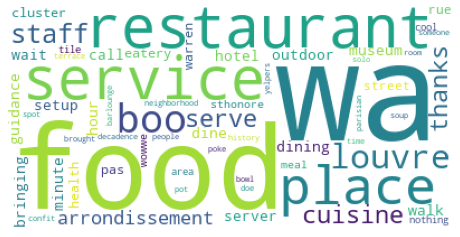

In [63]:
wordcloud = WordCloud(background_color = 'white', max_words = 60).generate(all_reviews)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

Nous remarquons que les sujets principaux sont le repas, le service, le restaurant, la localisation et le menu.

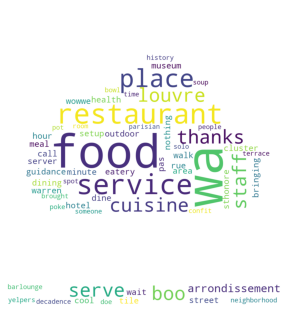

In [64]:
mask = np.array(Image.open("input\cloud.jpg"))
mask[mask == 1] = 255

wordcloud = WordCloud(background_color = "white", max_words = 60, mask = mask).generate(all_reviews)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Features : deux méthodes BOW & TF-IDF

### BOW

le modèle CBOW prédit le mot actuel en fonction des mots du contexte dans une fenêtre spécifique:
- La couche d'entrée contient les mots de contexte
- la couche de sortie contient le mot courant
- la couche cachée contient le nombre de dimensions dans lesquelles nous voulons représenter le mot actuel présent à la couche de sortie.

In [65]:
reviews.head(5)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,compound,feeling_pos,feeling_avg
22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hour louvre museum wa wait staff setup...,0.000,1.000,0.0000,0.000,Neutral
31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks guidance call restau...,0.047,0.389,0.9230,0.564,Positive
33,9zPoJDR7H1s0P0SeexSIwg,4.0,casual and lowkey place it was very relaxing t...,casual lowkey place was very relaxing dine ...,casual lowkey place was veri relax dine server...,casual lowkey place wa very relaxing dine serv...,casual lowkey place was very relaxing dine ser...,place dine server bringing,0.000,0.625,0.7778,0.375,Neutral
43,hiVILjoj4qcKApkY0q9CHw,4.0,the hostess from my hotel recommended this pla...,hostess hotel recommended place serve au...,hostess hotel recommend place serv authent fre...,hostess hotel recommended place serve authenti...,hostess hotel recommended place serve authenti...,hotel place serve cuisine outdoor wa,0.000,0.878,0.2023,0.122,Neutral
45,NaN,0.0,,,,,,,0.000,0.000,0.0000,0.000,Neutral


In [66]:
reviews = reviews.reset_index()

In [67]:
from  sklearn.feature_extraction.text  import CountVectorizer 
# créer un vecteur d'objet 
vectorizer = CountVectorizer()
corpus = reviews["words_subjects"]


In [68]:
# apprendre le vocabulaire et stocker la matrice creuse CountVectorizer dans X 
cbow = vectorizer.fit_transform(corpus).todense()
new_cols = vectorizer.get_feature_names()

In [69]:
# join the tfidf values to the existing dataframe
reviews = reviews.join(pd.DataFrame(cbow, columns=new_cols))

In [70]:
reviews.head(2)

,index,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,...,terrace,thanks,tile,time,wa,wait,walk,warren,wowwe,yelpers
0,22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hour louvre museum wa wait staff setup...,0.000,...,0,0,0,0,1,1,0,0,0,0
1,31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks guidance call restau...,0.047,...,0,1,0,0,0,0,0,0,0,0


### TF-IDF

Matrice avec les noms pour trouver les themes abordés dans le corpus. Puis après, refaire une matrice avec theme + word_ok pour avoir les sentiments sur les themes.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(reviews["words_subjects"]).todense()
new_cols = vectorizer.get_feature_names()


In [72]:
tfidf_df = pd.DataFrame(tfIdf, columns=new_cols)

In [73]:
tfidf_df

,area,arrondissement,barlounge,bit,boo,bowl,bringing,brought,cafe,call,...,terrace,thanks,tile,time,wa,wait,walk,warren,wowwe,yelpers
0,0.000000,0.000000,0.000000,0.000000,0.608596,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.151629,0.304298,0.00000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.419416,...,0.00000,0.369368,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.531991,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.239385,0.000000,0.00000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.345875,0.000000,0.34706,0.00000,0.000000,0.000000
6,0.000000,0.392911,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.222313,0.000000,0.00000,0.44615,0.000000,0.000000
7,0.384173,0.338330,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.384173,0.000000,0.000000,0.000000,0.00000,0.00000,0.384173,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.472362,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.235375,0.000000,0.00000,0.00000,0.000000,0.000000
9,0.000000,0.000000,0.469665,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000


In [74]:
reviews.head(2)

,index,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,...,terrace,thanks,tile,time,wa,wait,walk,warren,wowwe,yelpers
0,22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hour louvre museum wa wait staff setup...,0.000,...,0,0,0,0,1,1,0,0,0,0
1,31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks guidance call restau...,0.047,...,0,1,0,0,0,0,0,0,0,0


In [75]:
# join the tfidf values to the existing dataframe
reviews = reviews.join(tfidf_df, rsuffix='_tfidf')

In [76]:
reviews

,index,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,...,terrace_tfidf,thanks_tfidf,tile_tfidf,time_tfidf,wa_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,22,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hour louvre museum wa wait staff setup...,0.000,...,0.00000,0.000000,0.000000,0.000000,0.151629,0.304298,0.00000,0.00000,0.000000,0.000000
1,31,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks guidance call restau...,0.047,...,0.00000,0.369368,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
2,33,9zPoJDR7H1s0P0SeexSIwg,4.0,casual and lowkey place it was very relaxing t...,casual lowkey place was very relaxing dine ...,casual lowkey place was veri relax dine server...,casual lowkey place wa very relaxing dine serv...,casual lowkey place was very relaxing dine ser...,place dine server bringing,0.000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
3,43,hiVILjoj4qcKApkY0q9CHw,4.0,the hostess from my hotel recommended this pla...,hostess hotel recommended place serve au...,hostess hotel recommend place serv authent fre...,hostess hotel recommended place serve authenti...,hostess hotel recommended place serve authenti...,hotel place serve cuisine outdoor wa,0.000,...,0.00000,0.000000,0.000000,0.000000,0.239385,0.000000,0.00000,0.00000,0.000000,0.000000
4,45,NaN,0.0,,,,,,,0.000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
5,62,6VRDbCMuGKSxcYiNx6Sg4g,4.0,a five minute walk from the louvre this restau...,five minute walk louvre restaurant was amo...,five minut walk louvr restaur was among cluste...,five minute walk louvre restaurant wa among cl...,minute walk louvre restaurant was cluster othe...,minute walk louvre restaurant wa cluster eater...,0.000,...,0.00000,0.000000,0.000000,0.000000,0.345875,0.000000,0.34706,0.00000,0.000000,0.000000
6,103,95kmdLo02hNYlWoXFIkrTA,4.0,great restaurant in the er arrondissement down...,great restaurant arrondissement warren ...,great restaur arrondiss warren street rue stho...,great restaurant arrondissement warren street ...,great restaurant arrondissement warren streets...,arrondissement warren street rue sthonore wa,0.117,...,0.00000,0.000000,0.000000,0.000000,0.222313,0.000000,0.00000,0.44615,0.000000,0.000000
7,104,mbc9n_ALEiXUCAK_aj2Ayw,4.0,wowwe had a wonderful interesting meal here no...,wowwe had wonderful interesting meal nothing...,woww had wonder interest meal noth fanci tile ...,wowwe had wonderful interesting meal nothing f...,wowwe had wonderful interesting meal nothing f...,wowwe meal nothing tile arrondissement cool area,0.077,...,0.00000,0.000000,0.384173,0.000000,0.000000,0.000000,0.00000,0.00000,0.384173,0.000000
8,106,OfasF1MNlcvQ-s65rBGJ8w,4.0,this is a small neighborhood cafe for that it...,is small neighborhood cafe excellent c...,is small neighborhood cafe excel cous cous was...,is small neighborhood cafe excellent cous cous...,is small neighborhood cafe excellent cous cous...,neighborhood wa brought pot serve service,0.000,...,0.00000,0.000000,0.000000,0.000000,0.235375,0.000000,0.00000,0.00000,0.000000,0.000000
9,113,LlAibd1Hdo61qzN2PMCWsg,4.0,stunning parisian restaurant recently renovat...,stunning parisian restaurant recently renovat...,stun parisian restaur recent renov but retain ...,stunning parisian restaurant recently renovate...,stunning parisian restaurant recently renovate...,restaurant history decaden

Maintenant que nous avons ajouté nos features, nous pouvons réaliser une PCA afin de voir quelles sont les variables qui expliquent au mieux nos données.

# Analyse multidimensionnelle : ACP / T-SNE / UMAP

ajouts infos des methodes

In [77]:
del reviews["index"]

In [78]:
df_acp = reviews.copy()


In [79]:
df_acp.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,...,terrace_tfidf,thanks_tfidf,tile_tfidf,time_tfidf,wa_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hour louvre museum wa wait staff setup...,0.000,1.000,...,0.0,0.000000,0.0,0.0,0.151629,0.304298,0.0,0.0,0.0,0.0
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks guidance call restau...,0.047,0.389,...,0.0,0.369368,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [80]:
df_acp2 = df_acp.drop(["rw_id", "rw_rating", "rw_text", "new_text", "stemmed", "lemmatized", "text_tokens_pos_tagged", "feeling_avg", "words_subjects"], axis=1)

In [81]:
df_acp2.head(2)

,feeling_neg,feeling_neu,compound,feeling_pos,area,arrondissement,barlounge,bit,boo,bowl,...,terrace_tfidf,thanks_tfidf,tile_tfidf,time_tfidf,wa_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,0.000,1.000,0.000,0.000,0,0,0,0,2,0,...,0.0,0.000000,0.0,0.0,0.151629,0.304298,0.0,0.0,0.0,0.0
1,0.047,0.389,0.923,0.564,0,0,0,0,0,0,...,0.0,0.369368,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


### ACP

21
[1.74491950e+01 1.48592685e+01 1.45129049e+01 1.39464474e+01
 1.34877640e+01 1.29634384e+01 1.22550947e+01 1.03617824e+01
 1.02474921e+01 9.70973105e+00 9.67127610e+00 8.29635186e+00
 7.98887446e+00 7.27374756e+00 7.23161179e+00 6.65751613e+00
 6.22464783e+00 3.71045043e+00 2.84016431e+00 1.41224100e+00
 5.84079860e-30]
[9.13092361e-02 7.77565071e-02 7.59440343e-02 7.29798398e-02
 7.05796127e-02 6.78358890e-02 6.41292241e-02 5.42217814e-02
 5.36237159e-02 5.08096863e-02 5.06084568e-02 4.34136675e-02
 4.18046806e-02 3.80625199e-02 3.78420293e-02 3.48378657e-02
 3.25727254e-02 1.94162765e-02 1.48621890e-02 7.39006281e-03
 3.05640953e-32]
   Dimension  Valeurs propres  % variance expliquée  % cum. var. expliquée
0       Dim1     1.661828e+01                   9.0                    9.0
1       Dim2     1.415168e+01                   8.0                   17.0
2       Dim3     1.382181e+01                   8.0                   25.0
3       Dim4     1.328233e+01                   7.0  

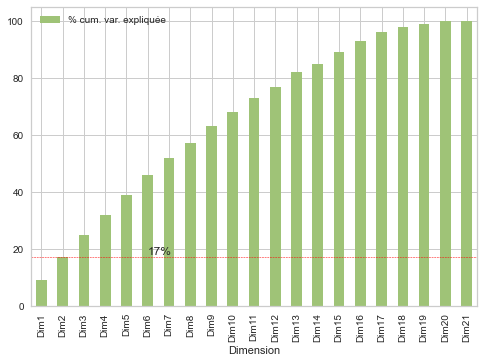

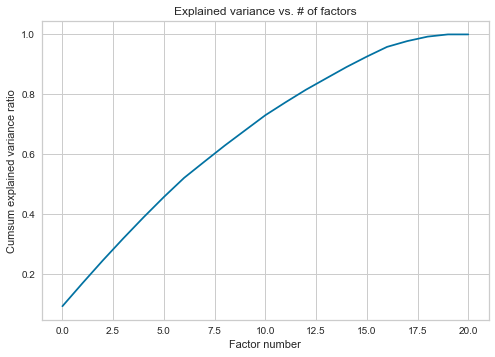

In [82]:
Z = pk_multi.amulti_acp_standard(df_acp2)
pk_multi.amulti_acp_choice_dim(df_acp2, Z)

Il faudrait 12 dimensions pour obtenir 80% de la variance expliquée.

In [478]:
df_acp.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,text_only_subjects,feeling_neg,feeling_neu,...,terrace_tfidf,thanks_tfidf,tile_tfidf,time_tfidf,wa_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hours museum wait staff setup,0.000,1.000,...,0.0,0.000000,0.0,0.0,0.151629,0.304298,0.0,0.0,0.0,0.0
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks reviewers guidance c...,0.047,0.389,...,0.0,0.369368,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


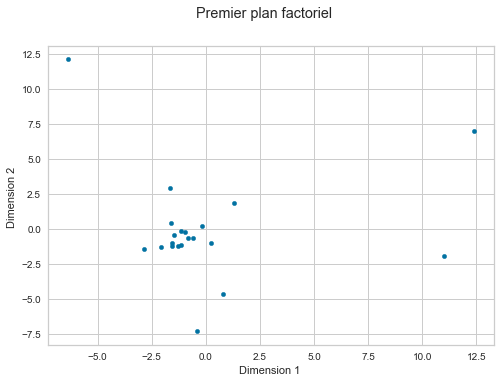

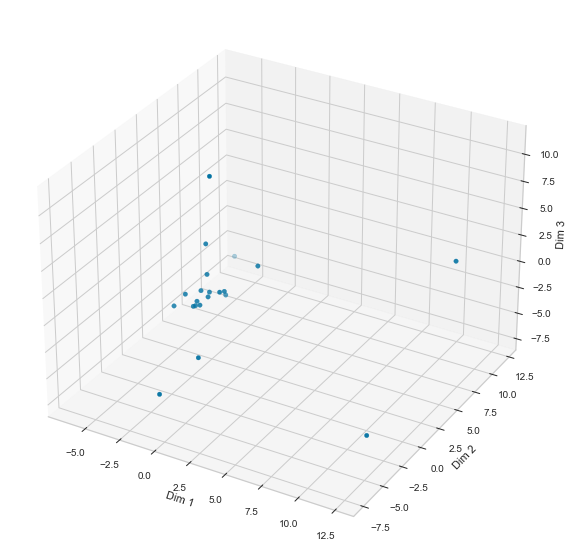

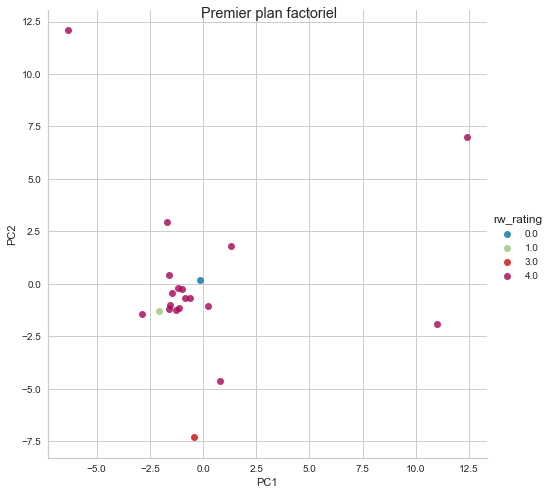

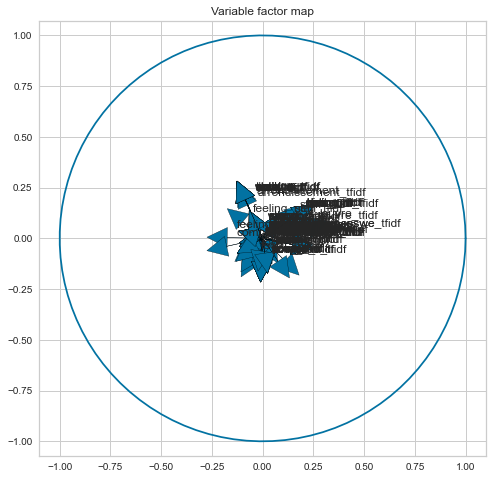

IndexError: index 21 is out of bounds for axis 0 with size 21

In [480]:
#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(df_acp2, Z, 3, df_acp, df_acp["text_only_subjects"], reviews["rw_rating"], "rw_rating")

### T-SNE

[t-SNE] Computing 20 nearest neighbors...
[t-SNE] Indexed 21 samples in 0.001s...
[t-SNE] Computed neighbors for 21 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 21 / 21
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.742786
[t-SNE] KL divergence after 300 iterations: 0.479328


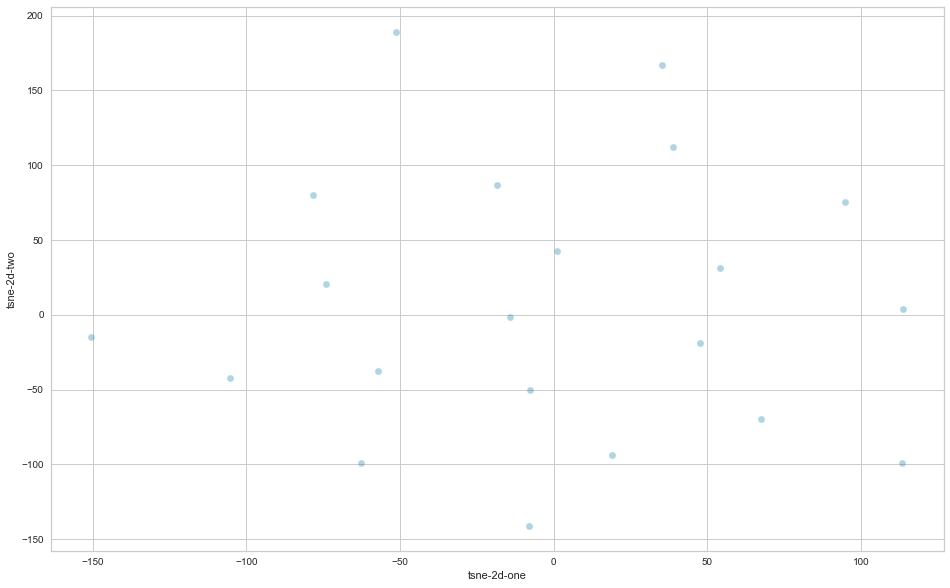

In [484]:
pk_multi.tsne_graph(df_acp2, group=0, by="")

### UMAP

In [485]:
pk_multi.umap_graphs(df_acp2)

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.



# Modèle : LDA / K-means / Bert

In [83]:
gc.collect()

20179

In [84]:
reviews.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,...,terrace_tfidf,thanks_tfidf,tile_tfidf,time_tfidf,wa_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hour louvre museum wa wait staff setup...,0.000,1.000,...,0.0,0.000000,0.0,0.0,0.151629,0.304298,0.0,0.0,0.0,0.0
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks guidance call restau...,0.047,0.389,...,0.0,0.369368,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [92]:
for i in reviews["words_subjects"]:
    print(word_tokenize(i))

['boo', 'boo', 'hour', 'louvre', 'museum', 'wa', 'wait', 'staff', 'setup', 'dining']
['restaurant', 'cuisine', 'thanks', 'guidance', 'call', 'restaurant']
['place', 'dine', 'server', 'bringing']
['hotel', 'place', 'serve', 'cuisine', 'outdoor', 'wa']
[]
['minute', 'walk', 'louvre', 'restaurant', 'wa', 'cluster', 'eatery', 'health', 'pas', 'wa']
['arrondissement', 'warren', 'street', 'rue', 'sthonore', 'wa']
['wowwe', 'meal', 'nothing', 'tile', 'arrondissement', 'cool', 'area']
['neighborhood', 'wa', 'brought', 'pot', 'serve', 'service']
['restaurant', 'history', 'decadence', 'room', 'barlounge']
['time', 'staff', 'people', 'solo', 'confit']
['terrace', 'food', 'wa', 'soup', 'poke', 'bowl', 'wa', 'someone', 'doe']
['thanks', 'yelpers', 'spot', 'wa', 'wa', 'parisian', 'food', 'lunch', 'rush']
['service', 'nice', 'night', 'place', 'food', 'wa', 'price']
['food', 'food', 'menu']
['decor', 'service', 'bit', 'food', 'wa', 'excellent']
['star', 'service', 'location', 'okay', 'food', 'luck', '

In [93]:
reviews["token_subjects"] = [word_tokenize(text) for text in reviews["words_subjects"]]

In [94]:
reviews

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,...,thanks_tfidf,tile_tfidf,time_tfidf,wa_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf,token_subjects
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at t...,boo boo came after few hours louvre muse...,boo boo came after few hour louvr museum was l...,boo boo came after few hour louvre museum wa l...,boo boo came few hours louvre museum was long ...,boo boo hour louvre museum wa wait staff setup...,0.000,1.000,...,0.000000,0.000000,0.000000,0.151629,0.304298,0.00000,0.00000,0.000000,0.000000,"[boo, boo, hour, louvre, museum, wa, wait, sta..."
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks...,very good restaurant french cuisine thanks ...,veri good restaur french cuisin thank review b...,very good restaurant french cuisine thanks rev...,very good restaurant french cuisine thanks rev...,restaurant cuisine thanks guidance call restau...,0.047,0.389,...,0.369368,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,"[restaurant, cuisine, thanks, guidance, call, ..."
2,9zPoJDR7H1s0P0SeexSIwg,4.0,casual and lowkey place it was very relaxing t...,casual lowkey place was very relaxing dine ...,casual lowkey place was veri relax dine server...,casual lowkey place wa very relaxing dine serv...,casual lowkey place was very relaxing dine ser...,place dine server bringing,0.000,0.625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,"[place, dine, server, bringing]"
3,hiVILjoj4qcKApkY0q9CHw,4.0,the hostess from my hotel recommended this pla...,hostess hotel recommended place serve au...,hostess hotel recommend place serv authent fre...,hostess hotel recommended place serve authenti...,hostess hotel recommended place serve authenti...,hotel place serve cuisine outdoor wa,0.000,0.878,...,0.000000,0.000000,0.000000,0.239385,0.000000,0.00000,0.00000,0.000000,0.000000,"[hotel, place, serve, cuisine, outdoor, wa]"
4,NaN,0.0,,,,,,,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,[]
5,6VRDbCMuGKSxcYiNx6Sg4g,4.0,a five minute walk from the louvre this restau...,five minute walk louvre restaurant was amo...,five minut walk louvr restaur was among cluste...,five minute walk louvre restaurant wa among cl...,minute walk louvre restaurant was cluster othe...,minute walk louvre restaurant wa cluster eater...,0.000,1.000,...,0.000000,0.000000,0.000000,0.345875,0.000000,0.34706,0.00000,0.000000,0.000000,"[minute, walk, louvre, restaurant, wa, cluster..."
6,95kmdLo02hNYlWoXFIkrTA,4.0,great restaurant in the er arrondissement down...,great restaurant arrondissement warren ...,great restaur arrondiss warren street rue stho...,great restaurant arrondissement warren street ...,great restaurant arrondissement warren streets...,arrondissement warren street rue sthonore wa,0.117,0.643,...,0.000000,0.000000,0.000000,0.222313,0.000000,0.00000,0.44615,0.000000,0.000000,"[arrondissement, warren, street, rue, sthonore..."
7,mbc9n_ALEiXUCAK_aj2Ayw,4.0,wowwe had a wonderful interesting meal here no...,wowwe had wonderful interesting meal nothing...,woww had wonder interest meal noth fanci tile ...,wowwe had wonderful interesting meal nothing f...,wowwe had wonderful interesting meal nothing f...,wowwe meal nothing tile arrondissement cool area,0.077,0.442,...,0.000000,0.384173,0.000000,0.000000,0.000000,0.00000,0.00000,0.384173,0.000000,"[wowwe, meal, nothing, tile, arrondissement, c..."
8,OfasF1MNlcvQ-s65rBGJ8w,4.0,this is a small neighborhood cafe for that it...,is small neighborhood cafe excellent c...,is small neighborhood cafe excel cous cous was...,is small neighborhood cafe excellent cous cous...,is small neighborhood cafe excellent cous cous...,neighborhood wa brought pot serve service,0.000,0.558,...,0.000000,0.000000,0.000000,0.235375,0.000000,0.00000,0.00000,0.000000,0.000000,"[nei

In [95]:
# Create Dictionary
id2word = corpora.Dictionary(reviews["token_subjects"])

# Create Corpus
texts = reviews["token_subjects"]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [96]:
id2word[0]

'boo'

In [97]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('boo', 2),
  ('dining', 1),
  ('hour', 1),
  ('louvre', 1),
  ('museum', 1),
  ('setup', 1),
  ('staff', 1),
  ('wa', 1),
  ('wait', 1)]]

In [98]:
corpus

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 2), (13, 1)],
 [(14, 1), (15, 1), (16, 1), (17, 1)],
 [(7, 1), (10, 1), (16, 1), (18, 1), (19, 1), (20, 1)],
 [],
 [(3, 1),
  (7, 2),
  (12, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)],
 [(7, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(27, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)],
 [(7, 1), (20, 1), (38, 1), (39, 1), (40, 1), (41, 1)],
 [(12, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(6, 1), (46, 1), (47, 1), (48, 1), (49, 1)],
 [(7, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1)],
 [(7, 2), (13, 1), (52, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)],
 [(7, 1), (16, 1), (41, 1), (52, 1), (62, 1), (63, 1), (64, 1)],
 [(52, 2), (65, 1)],
 [(7, 1), (41, 1), (52, 1), (66, 1), (67, 1), (68, 1)],
 [(12, 1), (41, 1), (52, 2), (69, 1), (70, 1), (71, 1), (72, 1)],
 [(52, 1), (73, 1), (74, 1), (75, 1)],
 [(76, 1), (

In [99]:
from gensim.models.ldamodel import LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=1, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [100]:
gc.collect()

491

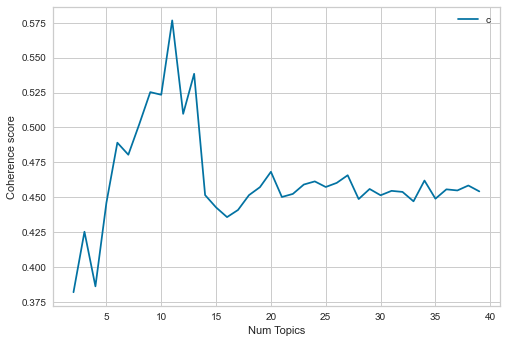

Num Topics = 2  has Coherence Value of 0.3821
Num Topics = 3  has Coherence Value of 0.4254
Num Topics = 4  has Coherence Value of 0.3863
Num Topics = 5  has Coherence Value of 0.446
Num Topics = 6  has Coherence Value of 0.4891
Num Topics = 7  has Coherence Value of 0.4805
Num Topics = 8  has Coherence Value of 0.5024
Num Topics = 9  has Coherence Value of 0.5253
Num Topics = 10  has Coherence Value of 0.5234
Num Topics = 11  has Coherence Value of 0.5766
Num Topics = 12  has Coherence Value of 0.5097
Num Topics = 13  has Coherence Value of 0.5384
Num Topics = 14  has Coherence Value of 0.4516
Num Topics = 15  has Coherence Value of 0.4428
Num Topics = 16  has Coherence Value of 0.4358
Num Topics = 17  has Coherence Value of 0.4409
Num Topics = 18  has Coherence Value of 0.4516
Num Topics = 19  has Coherence Value of 0.4573
Num Topics = 20  has Coherence Value of 0.4683
Num Topics = 21  has Coherence Value of 0.4502
Num Topics = 22  has Coherence Value of 0.4524
Num Topics = 23  has C

In [101]:
# Calculer les scores de cohérence entre 2 et 40 topics (Cela peut prendre un certain temps)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=1)

# Afficher un graphique
limit=40
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Affchier les coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))  #le 4 correspond au nombre de décimales du c

In [102]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [103]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.097*"wa" + 0.066*"boo" + 0.066*"food" + 0.034*"wait" + 0.034*"hour" + 0.034*"dining" + 0.034*"louvre" + 0.034*"museum" + 0.034*"setup" + 0.034*"spot"'), (1, '0.050*"seafood" + 0.050*"cool" + 0.050*"tile" + 0.050*"share" + 0.050*"meal" + 0.050*"tearsofhappinesswe" + 0.050*"wowwe" + 0.050*"salad" + 0.050*"nothing" + 0.050*"distance"'), (2, '0.011*"wa" + 0.011*"food" + 0.011*"service" + 0.011*"restaurant" + 0.011*"place" + 0.011*"cuisine" + 0.011*"serve" + 0.011*"menu" + 0.011*"arrondissement" + 0.011*"boo"'), (3, '0.011*"wa" + 0.011*"food" + 0.011*"place" + 0.011*"restaurant" + 0.011*"service" + 0.011*"menu" + 0.011*"thanks" + 0.011*"pasta" + 0.011*"staff" + 0.011*"bringing"'), (4, '0.074*"bit" + 0.074*"excellent" + 0.074*"decor" + 0.074*"service" + 0.074*"food" + 0.074*"wa" + 0.007*"restaurant" + 0.007*"place" + 0.007*"serve" + 0.007*"menu"'), (5, '0.195*"food" + 0.069*"drink" + 0.069*"menu" + 0.069*"service" + 0.069*"wa" + 0.006*"place" + 0.006*"restaurant" + 0.006*"bringing" +

In [104]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews["token_subjects"], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.3201212249696255

Coherence Score:  0.548147613737444


In [105]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.097*"wa" + 0.066*"boo" + 0.066*"food" + 0.034*"wait" + 0.034*"hour" + '
  '0.034*"dining" + 0.034*"louvre" + 0.034*"museum" + 0.034*"setup" + '
  '0.034*"spot"'),
 (1,
  '0.050*"seafood" + 0.050*"cool" + 0.050*"tile" + 0.050*"share" + '
  '0.050*"meal" + 0.050*"tearsofhappinesswe" + 0.050*"wowwe" + 0.050*"salad" + '
  '0.050*"nothing" + 0.050*"distance"'),
 (2,
  '0.011*"wa" + 0.011*"food" + 0.011*"service" + 0.011*"restaurant" + '
  '0.011*"place" + 0.011*"cuisine" + 0.011*"serve" + 0.011*"menu" + '
  '0.011*"arrondissement" + 0.011*"boo"'),
 (3,
  '0.011*"wa" + 0.011*"food" + 0.011*"place" + 0.011*"restaurant" + '
  '0.011*"service" + 0.011*"menu" + 0.011*"thanks" + 0.011*"pasta" + '
  '0.011*"staff" + 0.011*"bringing"'),
 (4,
  '0.074*"bit" + 0.074*"excellent" + 0.074*"decor" + 0.074*"service" + '
  '0.074*"food" + 0.074*"wa" + 0.007*"restaurant" + 0.007*"place" + '
  '0.007*"serve" + 0.007*"menu"'),
 (5,
  '0.195*"food" + 0.069*"drink" + 0.069*"menu" + 0.069*"service" + 0

In [106]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9503,"wa, boo, food, wait, hour, dining, louvre, mus...","[boo, boo, hour, louvre, museum, wa, wait, sta..."
1,1,7.0,0.9243,"food, wa, restaurant, service, place, cuisine,...","[restaurant, cuisine, thanks, guidance, call, ..."
2,2,9.0,0.8879,"place, wa, arrondissement, night, nice, street...","[place, dine, server, bringing]"
3,3,6.0,0.9184,"wa, eatery, pas, cluster, walk, minute, health...","[hotel, place, serve, cuisine, outdoor, wa]"
4,4,7.0,0.1631,"food, wa, restaurant, service, place, cuisine,...",[]
5,5,6.0,0.9492,"wa, eatery, pas, cluster, walk, minute, health...","[minute, walk, louvre, restaurant, wa, cluster..."
6,6,9.0,0.9219,"place, wa, arrondissement, night, nice, street...","[arrondissement, warren, street, rue, sthonore..."
7,7,1.0,0.9291,"seafood, cool, tile, share, meal, tearsofhappi...","[wowwe, meal, nothing, tile, arrondissement, c..."
8,8,7.0,0.9243,"food, wa, restaurant, service, place, cuisine,...","[neighborhood, wa, brought, pot, serve, service]"
9,9,8.0,0.9020,"decadence, barlounge, room, history, restauran...","[restaurant, history, decadence, room, barlounge]"


In [136]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,token_subjects
0,0.0,0.9503,"wa, boo, food, wait, hour, dining, louvre, museum, setup, spot","[boo, boo, hour, louvre, museum, wa, wait, staff, setup, dining]"
1,7.0,0.9243,"food, wa, restaurant, service, place, cuisine, serve, thanks, someone, poke","[restaurant, cuisine, thanks, guidance, call, restaurant]"
2,9.0,0.8879,"place, wa, arrondissement, night, nice, street, price, staff, warren, solo","[place, dine, server, bringing]"
3,6.0,0.9184,"wa, eatery, pas, cluster, walk, minute, health, louvre, outdoor, hotel","[hotel, place, serve, cuisine, outdoor, wa]"
4,7.0,0.1631,"food, wa, restaurant, service, place, cuisine, serve, thanks, someone, poke",[]
5,6.0,0.9492,"wa, eatery, pas, cluster, walk, minute, health, louvre, outdoor, hotel","[minute, walk, louvre, restaurant, wa, cluster, eatery, health, pas, wa]"
6,9.0,0.9219,"place, wa, arrondissement, night, nice, street, price, staff, warren, solo","[arrondissement, warren, street, rue, sthonore, wa]"
7,1.0,0.9291,"seafood, cool, tile, share, meal, tearsofhappinesswe, wowwe, salad, nothing, distance","[wowwe, meal, nothing, tile, arrondissement, cool, area]"
8,7.0,0.9243,"food, wa, restaurant, service, place, cuisine, serve, thanks, someone, poke","[neighborhood, wa, brought, pot, serve, service]"
9,8.0,0.9020,"decadence, barlounge, room, history, restaurant, wa, food, place, service, menu","[restaurant, history, decadence, room, barlounge]"


In [107]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9503,"wa, boo, food, wait, hour, dining, louvre, museum, setup, spot","[boo, boo, hour, louvre, museum, wa, wait, staff, setup, dining]"
1,1.0,0.9291,"seafood, cool, tile, share, meal, tearsofhappinesswe, wowwe, salad, nothing, distance","[wowwe, meal, nothing, tile, arrondissement, cool, area]"
2,4.0,0.9169,"bit, excellent, decor, service, food, wa, restaurant, place, serve, menu","[decor, service, bit, food, wa, excellent]"
3,5.0,0.8827,"food, drink, menu, service, wa, place, restaurant, bringing, serve, arrondissement","[food, wa, service, drink]"
4,6.0,0.9492,"wa, eatery, pas, cluster, walk, minute, health, louvre, outdoor, hotel","[minute, walk, louvre, restaurant, wa, cluster, eatery, health, pas, wa]"
5,7.0,0.9480,"food, wa, restaurant, service, place, cuisine, serve, thanks, someone, poke","[terrace, food, wa, soup, poke, bowl, wa, someone, doe]"
6,8.0,0.9020,"decadence, barlounge, room, history, restaurant, wa, food, place, service, menu","[restaurant, history, decadence, room, barlounge]"
7,9.0,0.9322,"place, wa, arrondissement, night, nice, street, price, staff, warren, solo","[service, nice, night, place, food, wa, price]"


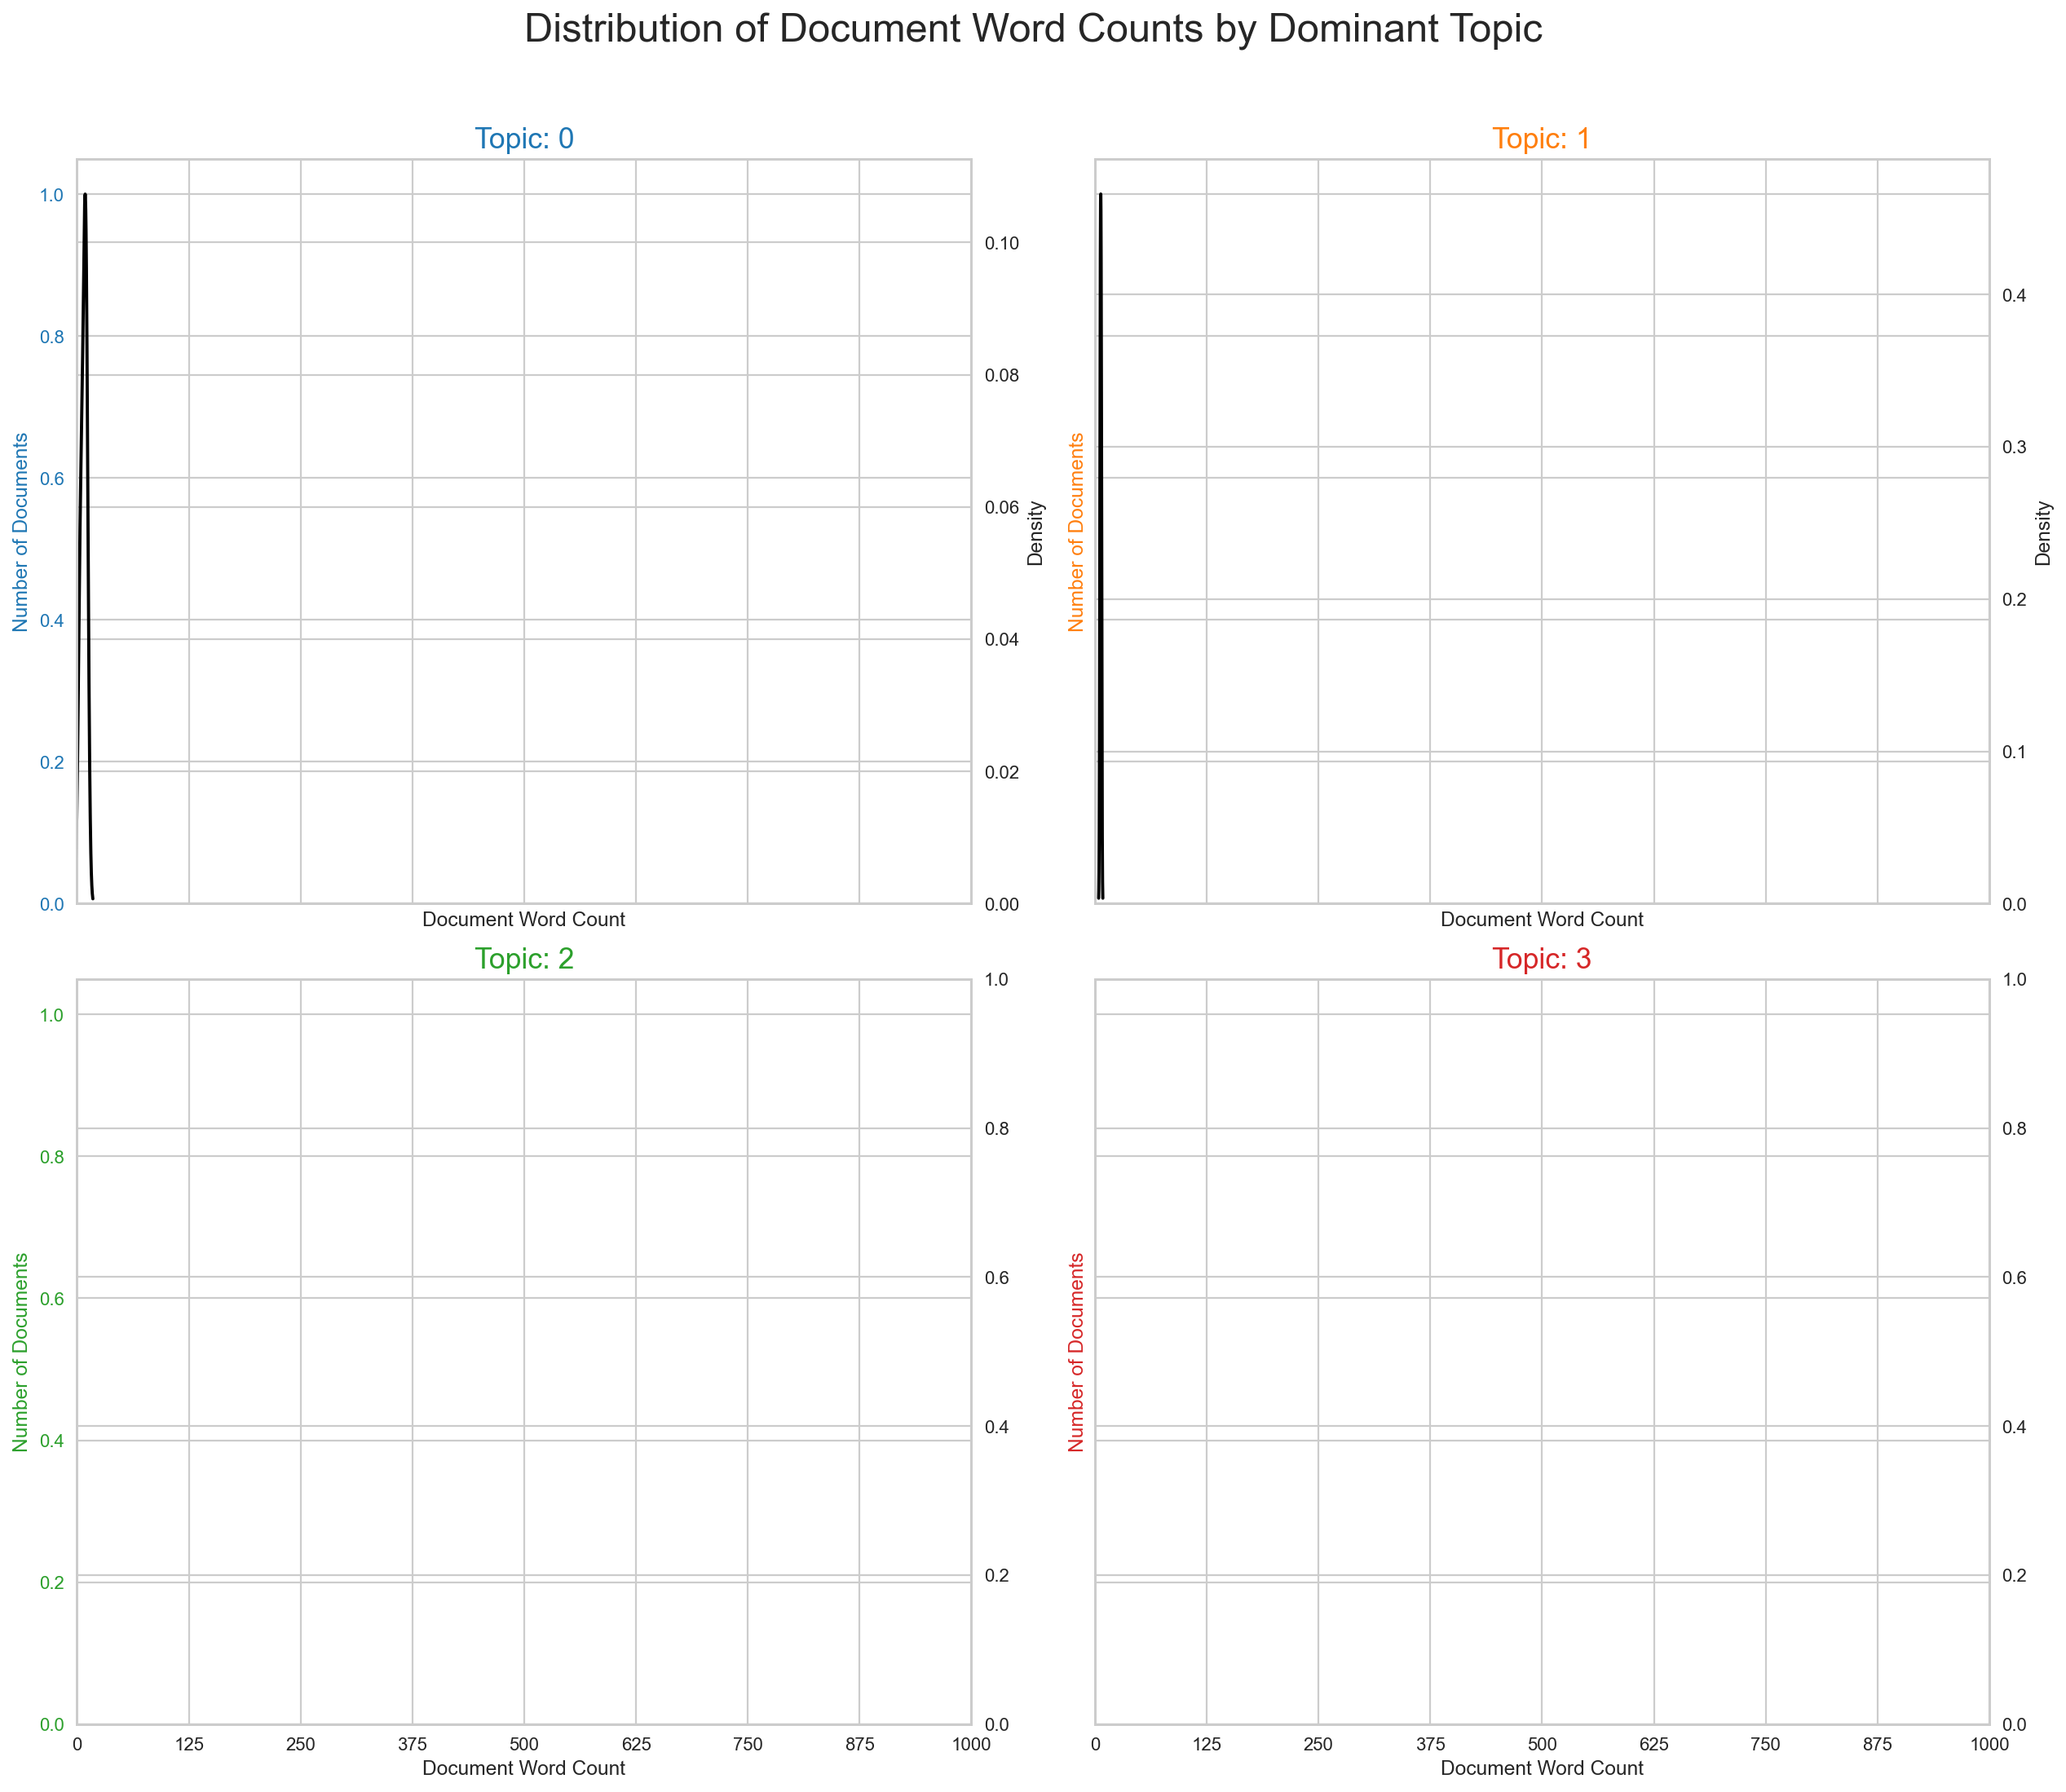

In [108]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

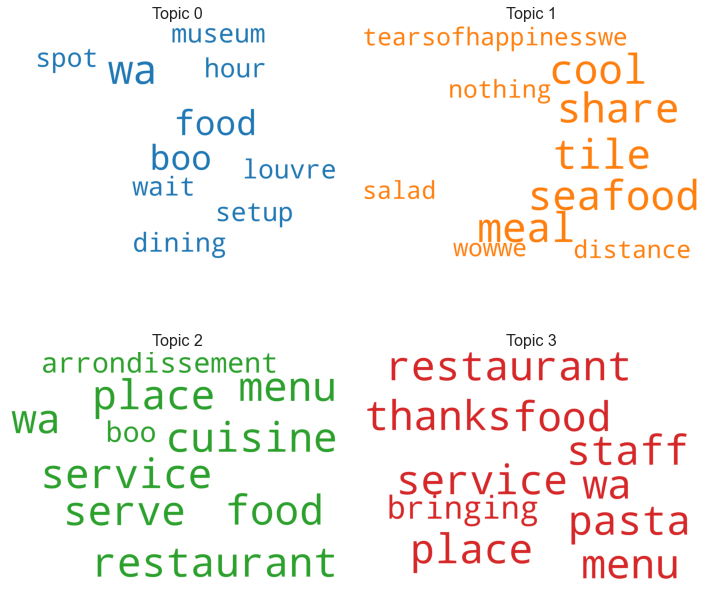

In [109]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2343665168.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2343665168.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2343665168.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\aurel\AppData\Local\Temp\ipykernel_8832\2343665168.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


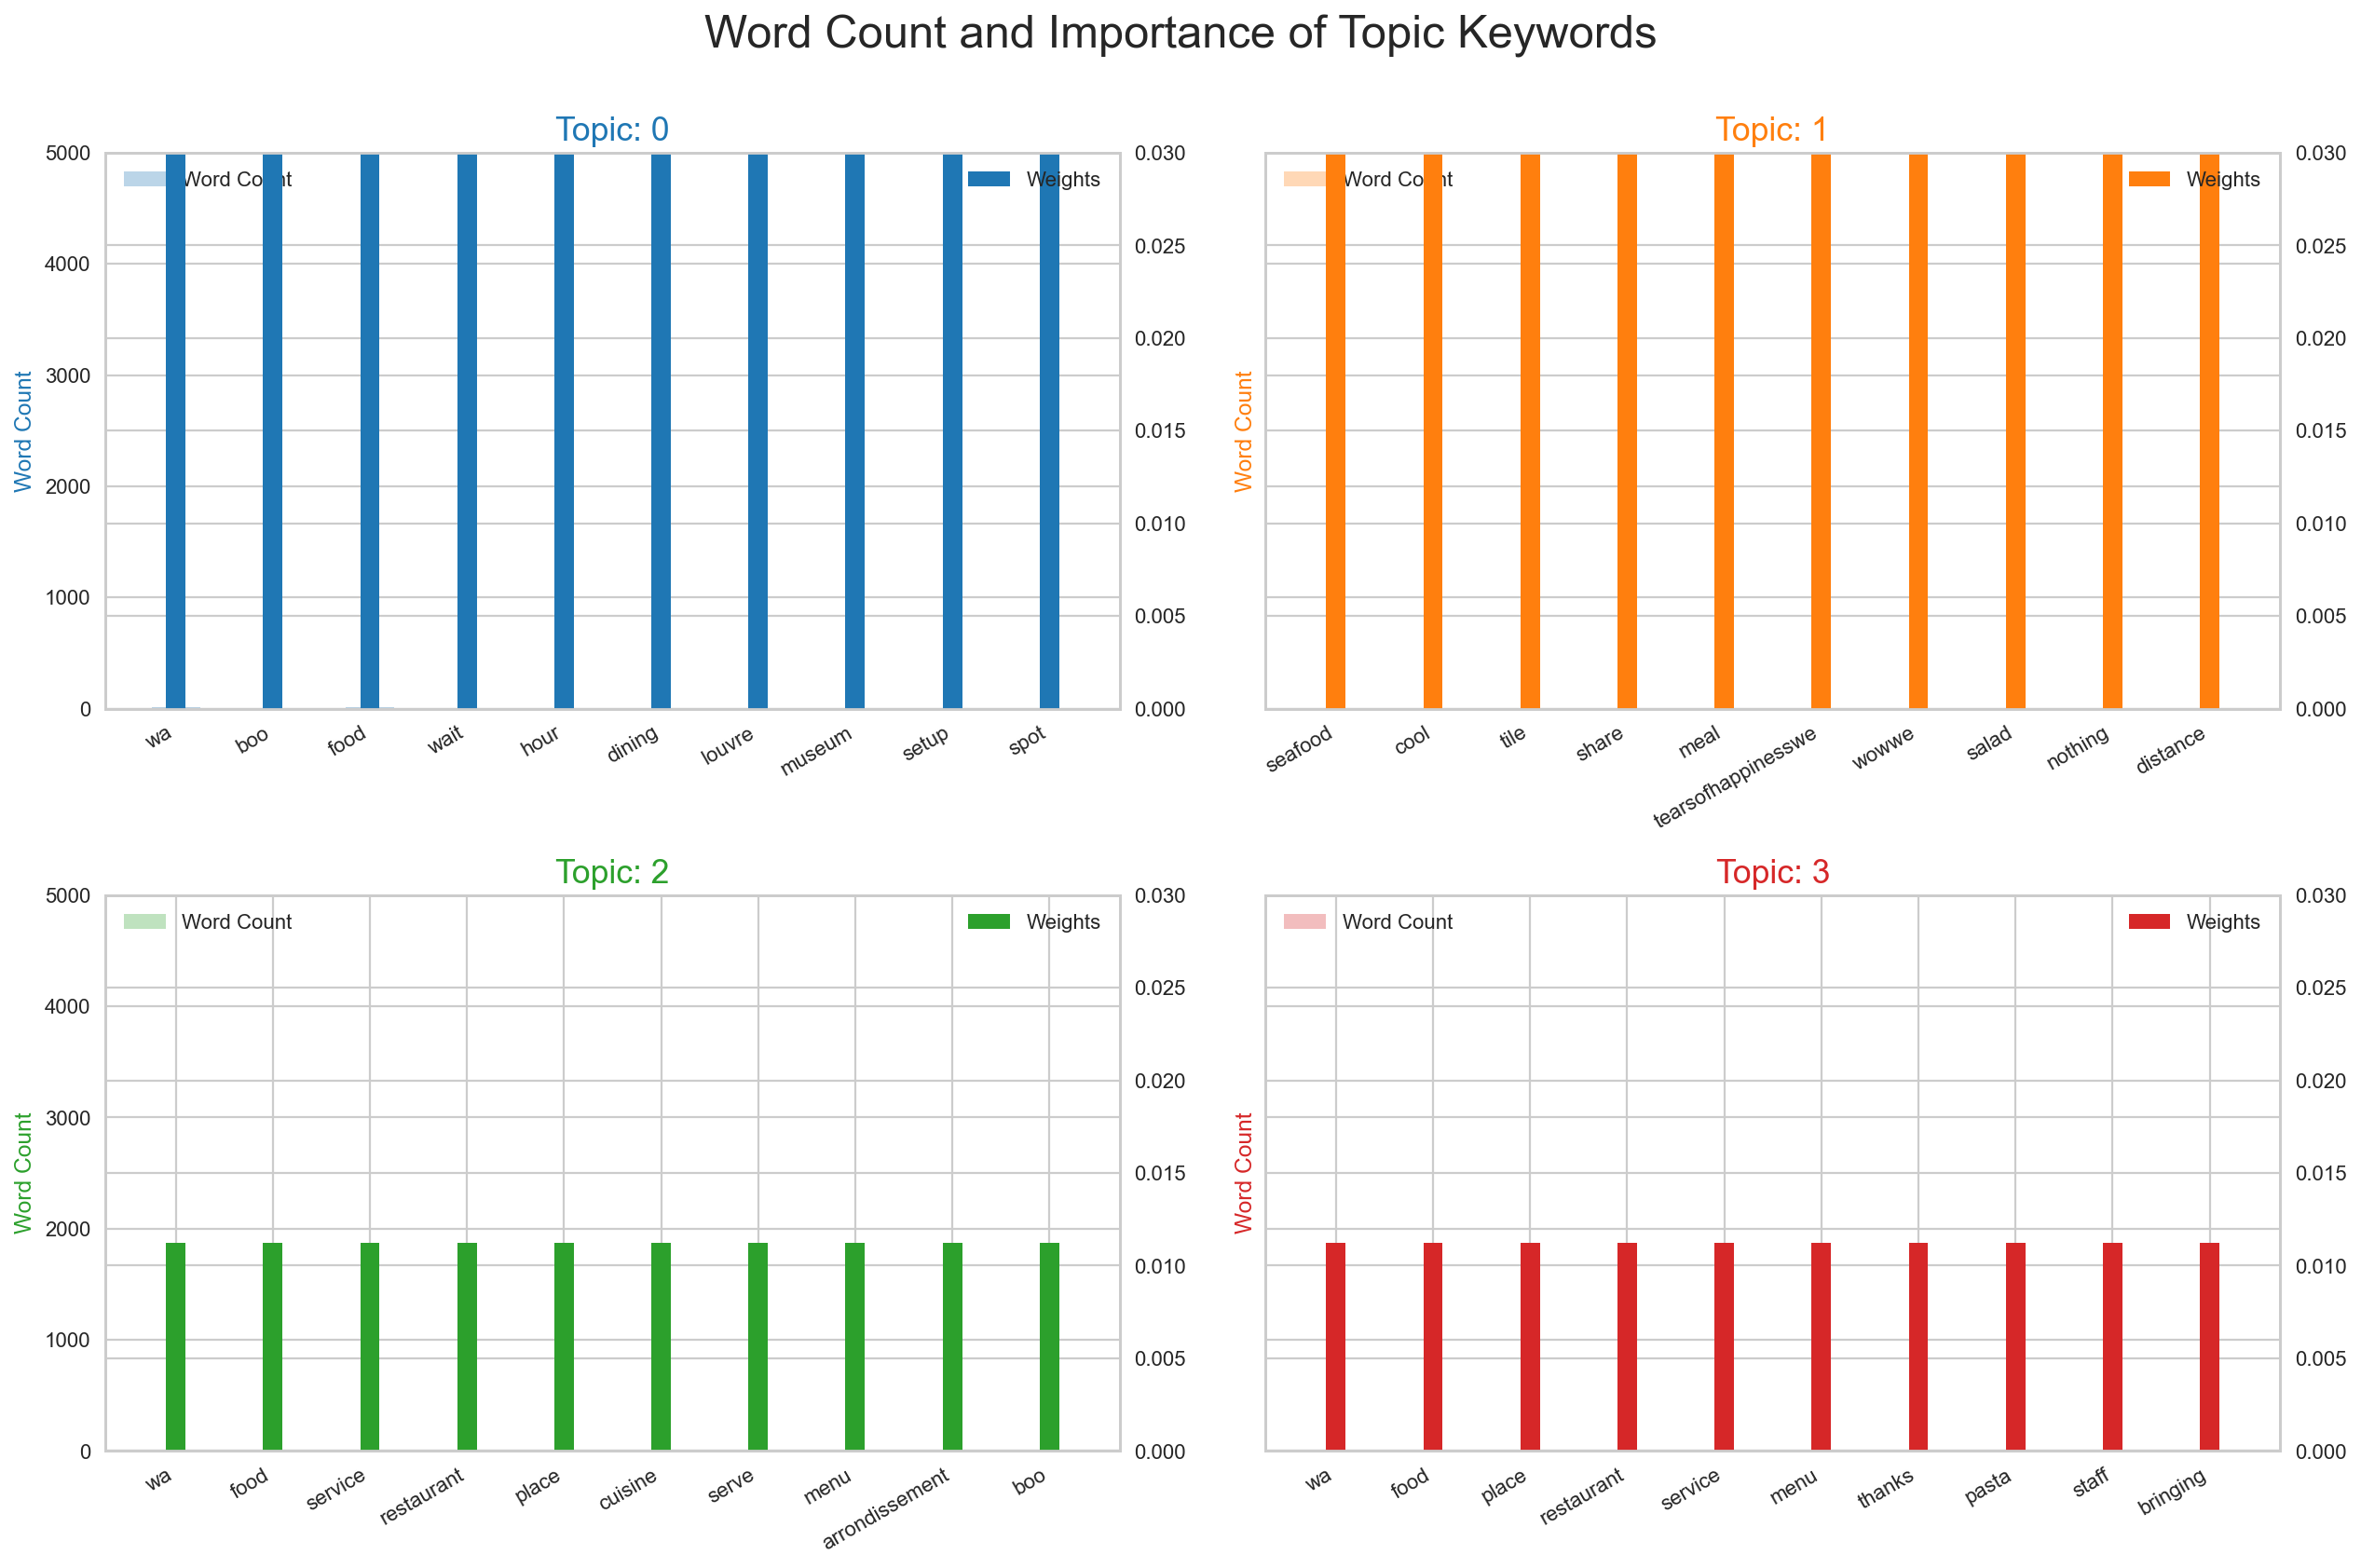

In [110]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

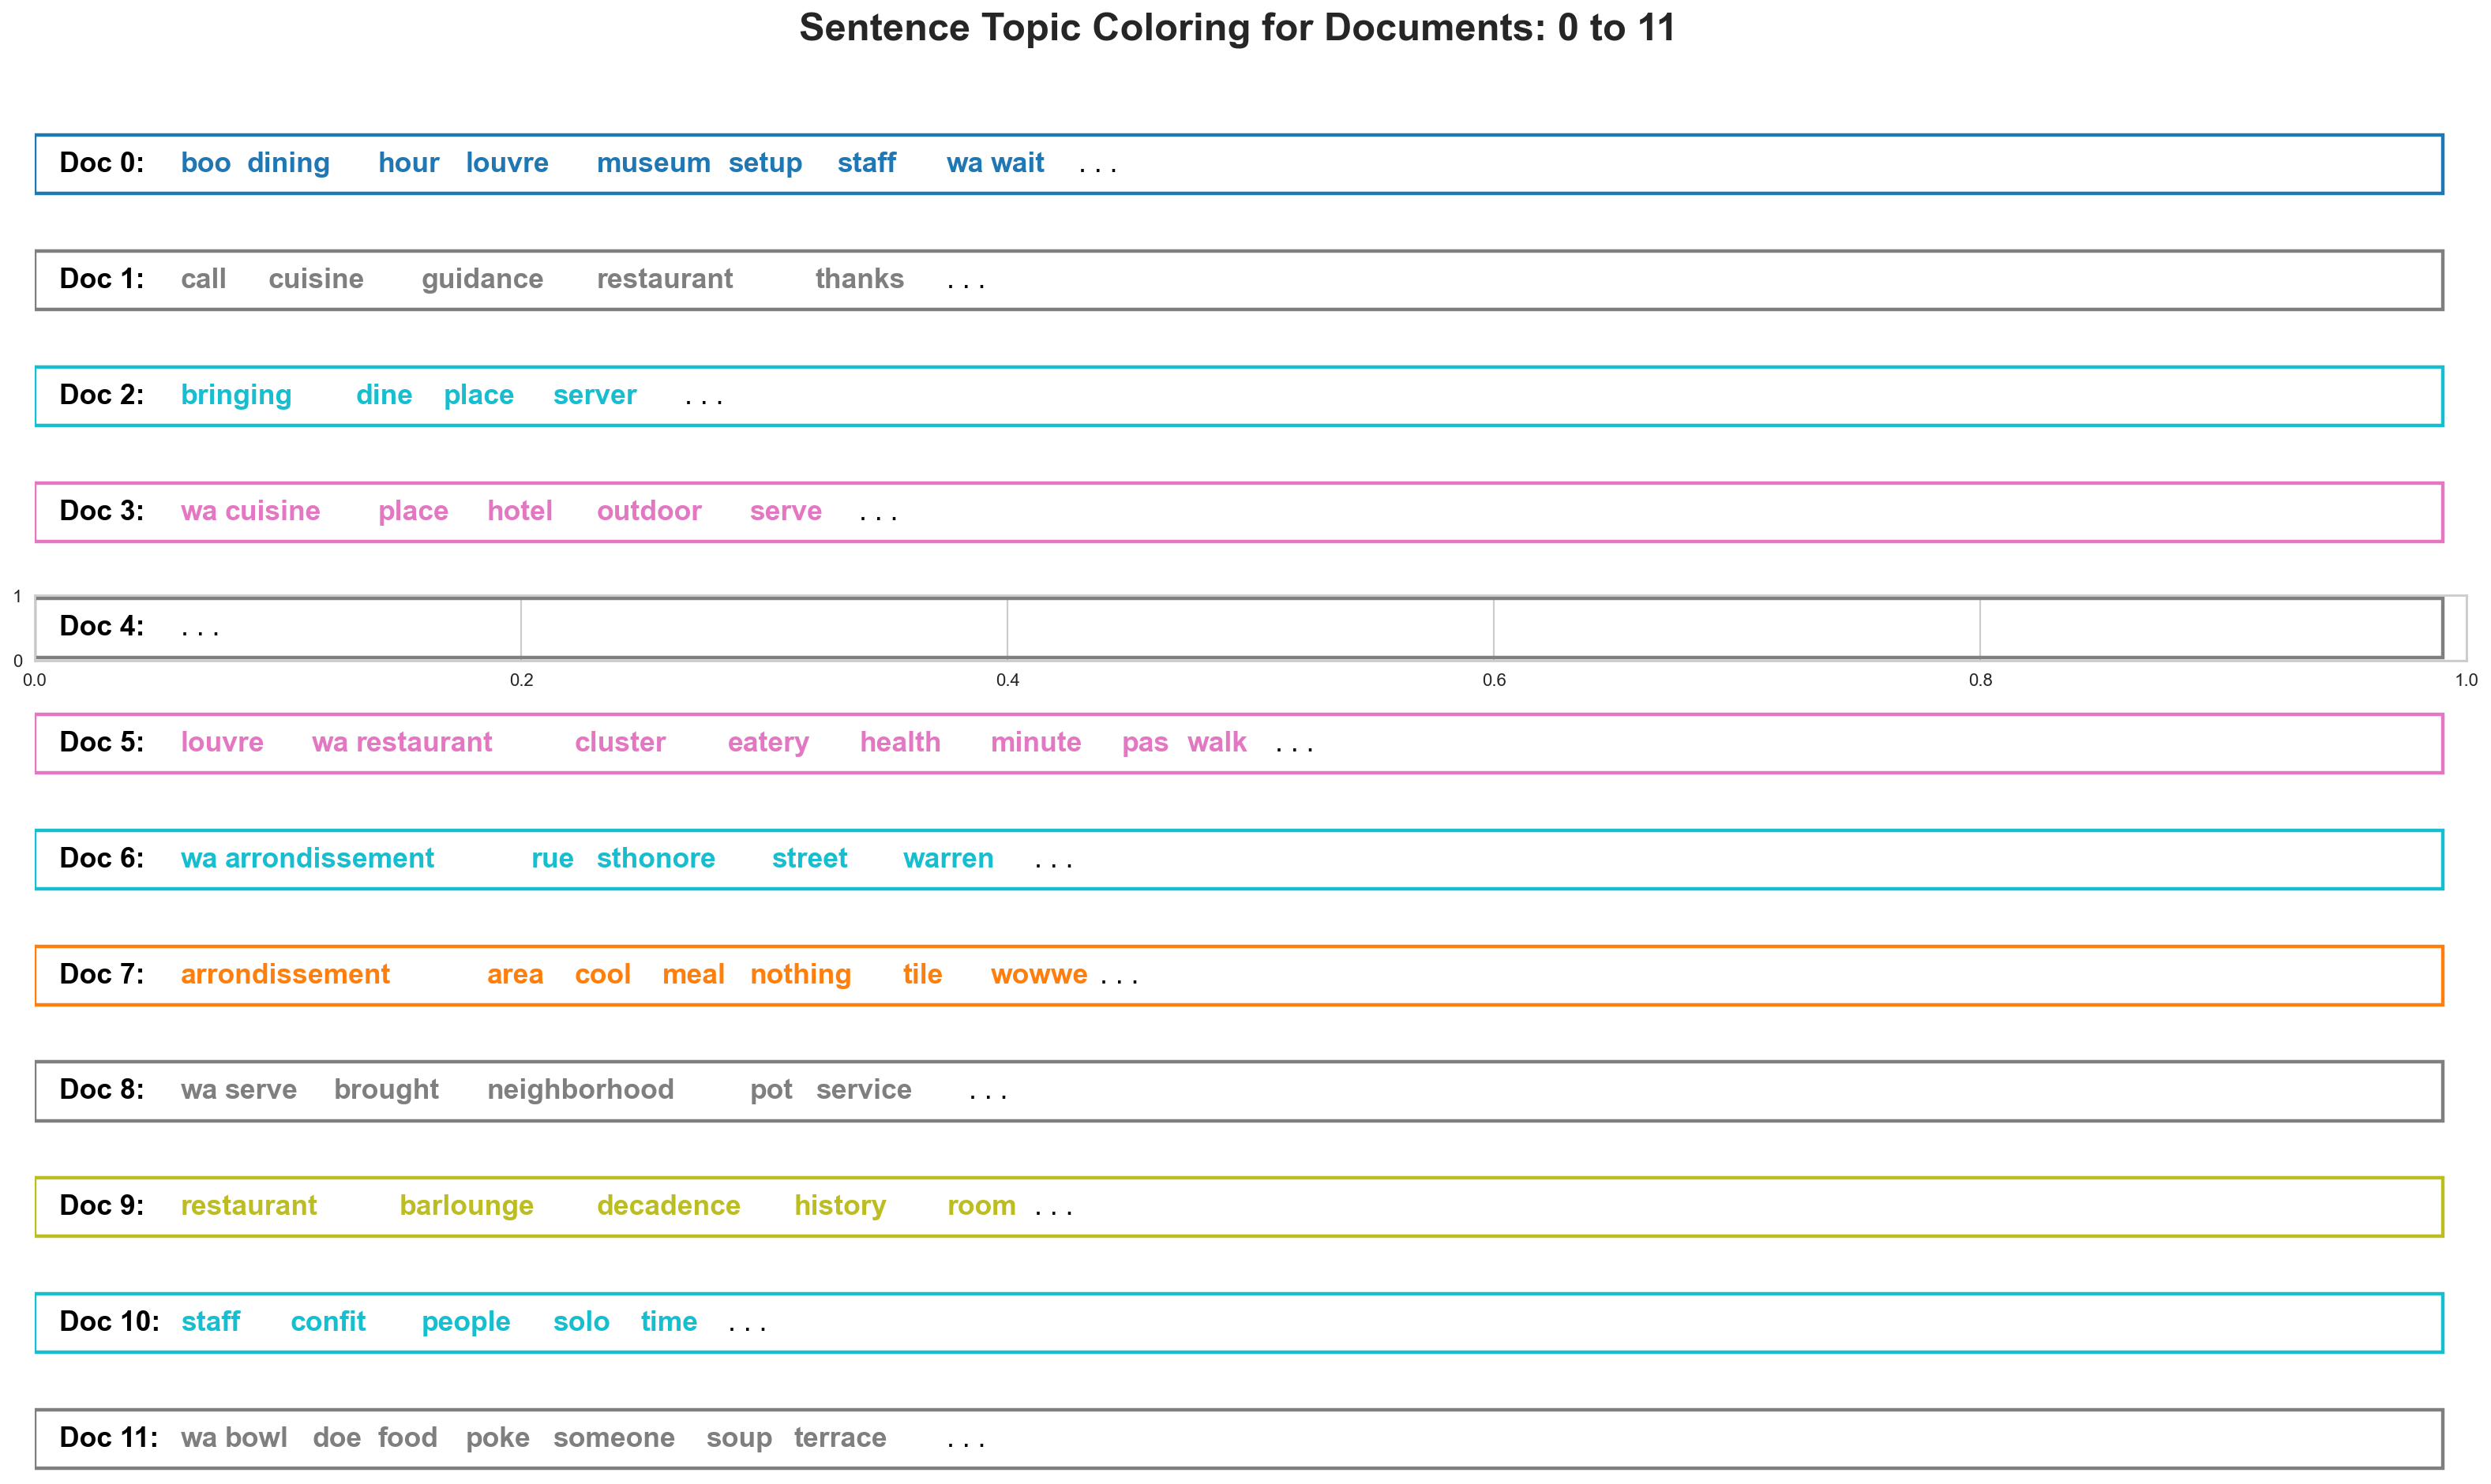

In [111]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [112]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.178497
[t-SNE] KL divergence after 1000 iterations: 0.392186


Loading BokehJS ...

In [113]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=id2word)
vis

ModuleNotFoundError: No module named 'pyLDAvis.gensim'

## Bert

In [101]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [4]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


In [102]:
import gc
gc.collect()

3565

### K-means

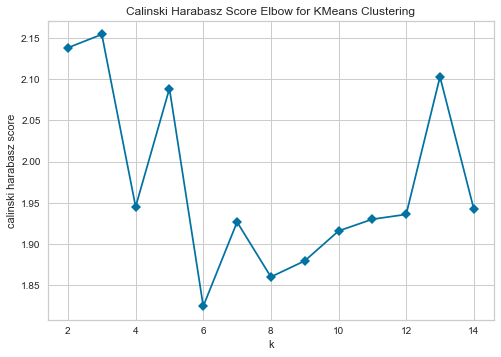

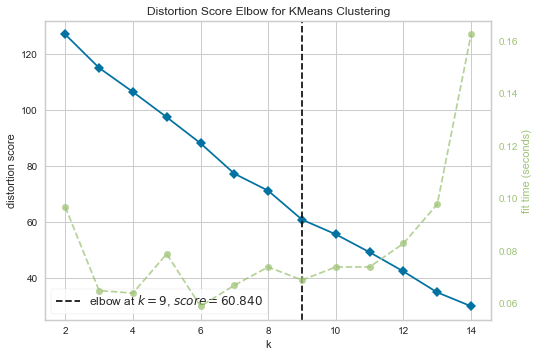

In [105]:
pk_multi_unsp.amulti_kmeans_elbow(df_acp2)

In [114]:
X = df_acp2.copy()

In [125]:
silhouette, cluster_res = pk_multi_unsp.kmsplus_iter(1, X, 9, 500, 0)

Silhouette Coefficient:  0.044468570643191  - nb clusters :  9
-----------------------------------------------------------------------------------


In [126]:
df_km = pk_multi_unsp.kmplus_assignclass(df_acp,X, 9, 500)

In [127]:
df_km

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,...,thanks_tfidf,tile_tfidf,time_tfidf,wa_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf,classe
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hour louvre museum wa wait staff setup dining,0.000,1.000,...,0.000000,0.000000,0.000000,0.151629,0.304298,0.00000,0.00000,0.000000,0.000000,7
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks guidance call restaurant,0.047,0.389,...,0.369368,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1
2,9zPoJDR7H1s0P0SeexSIwg,4.0,casual and lowkey place it was very relaxing to dine here the server was keen on recognizing us ...,casual lowkey place was very relaxing dine server was keen recognizing us americans conv...,casual lowkey place was veri relax dine server was keen recogn us american convers us bring,casual lowkey place wa very relaxing dine server wa keen recognizing u american conversed u brin...,casual lowkey place was very relaxing dine server was keen recognizing us americans conversed us...,place dine server bringing,0.000,0.625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1
3,hiVILjoj4qcKApkY0q9CHw,4.0,the hostess from my hotel recommended this place as they serve authentic french cuisine came to...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor...,hostess hotel recommend place serv authent french cuisin came restaur outdoor dine was pack,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hostess hotel recommended place serve authentic french cuisine came restaurant outdoor dining wa...,hotel place serve cuisine outdoor wa,0.000,0.878,...,0.000000,0.000000,0.000000,0.239385,0.000000,0.00000,0.00000,0.000000,0.000000,1
4,NaN,0.0,,,,,,,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1
5,6VRDbCMuGKSxcYiNx6Sg4g,4.0,a five minute walk from the louvre this restaurant was among a cluster of other eateries they a...,five minute walk louvre restaurant was among cluster other eateries also checked health...,five minut walk louvr restaur was among cluster other eateri also check health pass like was,five minute walk louvre restaurant wa among cluster other eatery also checked health pas like wa,minute walk louvre restaurant was cluster other eateries also checked health pass was,minute walk louvre restaurant wa cluster eatery health pas wa,0.000,1.000,...,0.000000,0.000000,0.000000,0.345875,0.000000,0.34706,0.00000,0.000000,0.000000,3
6,95kmdLo02hNYlWoXFIkrTA,4.0,great restaurant in the er arrondissement down in a warren of streets off the rue sthonore i had...,great restaurant arrondissement warren streets rue sthonore had gone alone without bo...,great restaur arrondiss warren street rue sthonor had gone alon without book was immedi,great restaurant arrondissement warren street rue sthonore had gone alone without bookin

In [131]:
pk_multi_unsp.graphs_profils(df_km,0,9, ["feeling_neu", "feeling_neg", "feeling_pos"])

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [133]:
df_km.head(2)

,rw_id,rw_rating,rw_text,new_text,stemmed,lemmatized,text_tokens_pos_tagged,words_subjects,feeling_neg,feeling_neu,...,thanks_tfidf,tile_tfidf,time_tfidf,wa_tfidf,wait_tfidf,walk_tfidf,warren_tfidf,wowwe_tfidf,yelpers_tfidf,classe
0,e970XRRbYSDC83PEADB1gw,4.0,boo boo and i came here after a few hours at the louvre museum there was a long wait but it move...,boo boo came after few hours louvre museum was long wait but moved fast staff setup ...,boo boo came after few hour louvr museum was long wait but move fast staff setup make dine just,boo boo came after few hour louvre museum wa long wait but moved fast staff setup make dining just,boo boo came few hours louvre museum was long wait moved fast staff setup makes dining just,boo boo hour louvre museum wa wait staff setup dining,0.000,1.000,...,0.000000,0.0,0.0,0.151629,0.304298,0.0,0.0,0.0,0.0,7
1,WZgU_NdPlyXWHBuQi3LEPA,4.0,very good restaurant for french cuisine thanks to the reviewers before me leave a good guidance ...,very good restaurant french cuisine thanks reviewers before leave good guidance definitely ...,veri good restaur french cuisin thank review befor leav good guidanc definit accur true call res...,very good restaurant french cuisine thanks reviewer before leave good guidance definitely accura...,very good restaurant french cuisine thanks reviewers leave good guidance definitely accurate tru...,restaurant cuisine thanks guidance call restaurant,0.047,0.389,...,0.369368,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1


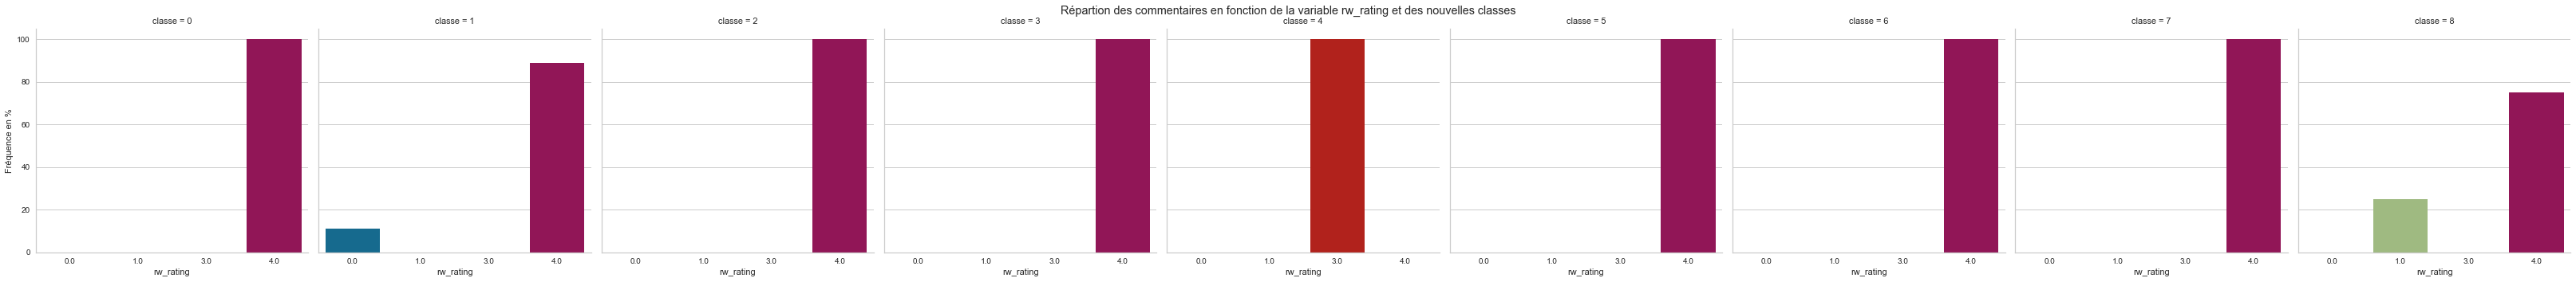

In [134]:
t = pd.crosstab(df_km.rw_rating,
                df_km.classe,
                normalize="columns")
t = t.assign(rw_rating=t.index)
tm = pd.melt(t, id_vars="rw_rating")
tm = tm.assign(value=100 * tm.value)
ax=sns.catplot(x="rw_rating",
               y="value", 
               col="classe",
               data=tm,
               kind="bar")
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Répartion des commentaires en fonction de la variable rw_rating et des nouvelles classes")
ax.set_axis_labels("rw_rating","Fréquence en %")
plt.show()

In [135]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9503,"wa, boo, food, wait, hour, dining, louvre, museum, setup, spot","[boo, boo, hour, louvre, museum, wa, wait, staff, setup, dining]"
1,1.0,0.9291,"seafood, cool, tile, share, meal, tearsofhappinesswe, wowwe, salad, nothing, distance","[wowwe, meal, nothing, tile, arrondissement, cool, area]"
2,4.0,0.9169,"bit, excellent, decor, service, food, wa, restaurant, place, serve, menu","[decor, service, bit, food, wa, excellent]"
3,5.0,0.8827,"food, drink, menu, service, wa, place, restaurant, bringing, serve, arrondissement","[food, wa, service, drink]"
4,6.0,0.9492,"wa, eatery, pas, cluster, walk, minute, health, louvre, outdoor, hotel","[minute, walk, louvre, restaurant, wa, cluster, eatery, health, pas, wa]"
5,7.0,0.9480,"food, wa, restaurant, service, place, cuisine, serve, thanks, someone, poke","[terrace, food, wa, soup, poke, bowl, wa, someone, doe]"
6,8.0,0.9020,"decadence, barlounge, room, history, restaurant, wa, food, place, service, menu","[restaurant, history, decadence, room, barlounge]"
7,9.0,0.9322,"place, wa, arrondissement, night, nice, street, price, staff, warren, solo","[service, nice, night, place, food, wa, price]"


In [168]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=X)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

In [169]:
model.cluster_centers_

array([[ 2.90000000e-02,  6.12875000e-01,  7.83787500e-01,
         3.58000000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.25000000e-01,  0.00000000e+00,
         1.25000000e-01,  0.00000000e+00,  1.25000000e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.25000000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.25000000e-01,  1.25000000e-01,
         0.00000000e+00,  0.00000000e+00,  1.25000000e-01,
         0.00000000e+00,  1.12500000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.25000000e-01,  0.00000000e+00,  1.25000000e-01,
         1.25000000e-01,  0.00000000e+00,  1.25000000e-01,
         0.00000000e+00,  0.00000000e+00,  1.25000000e-01,
         1.25000000e-01,  1.25000000e-01,  0.00000000e+0

In [170]:
all_reviews

'boo boo hour louvre museum wa wait staff setup dining restaurant cuisine thanks guidance call restaurant place dine server bringing hotel place serve cuisine outdoor wa  minute walk louvre restaurant wa cluster eatery health pas wa arrondissement warren street rue sthonore wa wowwe meal nothing tile arrondissement cool area neighborhood wa brought pot serve service restaurant history decadence room barlounge time staff people solo confit terrace food wa soup poke bowl wa someone doe thanks yelpers spot wa wa parisian food lunch rush service nice night place food wa price food food menu decor service bit food wa excellent star service location okay food luck restaurant food experience fumoir food setting tearsofhappinesswe distance seafood pasta salad share food wa service drink place du cochon instance reservation corner cafe'

In [171]:
w2v_model = Word2Vec(sentences=tag_fd,
                     min_count=3, 
                     window=4, 
                     size=182, 
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [174]:
tag_fd

FreqDist({'NN': 955, 'JJ': 692, 'RB': 304, 'VBD': 303, 'NNS': 206, 'VBN': 136, 'VBZ': 133, 'VBP': 132, 'VBG': 109, 'IN': 106, ...})

In [172]:
from gensim.models import Word2Vec
word_vectors = w2v_model.wv

In [173]:
from gensim.models import Word2Vec
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('P', 0.13202917575836182),
 ('D', 0.05591273307800293),
 ('S', 0.029793161898851395),
 ('B', 0.026701901108026505),
 ('V', 0.02134489268064499),
 ('W', -0.024759430438280106),
 ('R', -0.053366273641586304),
 ('J', -0.06595438718795776),
 ('N', -0.07397156208753586),
 ('C', -0.08587605506181717)]